<a href="https://colab.research.google.com/github/shubhamscifi/Instacart-Market-Basket-Analysis/blob/main/2.%20Exploratory%20Data%20Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **[Instacart Market Basket Analysis](https://www.kaggle.com/c/instacart-market-basket-analysis/)**

---
- Given order_id predict all the products that the user will reorder.

---








## Importing libraries

In [ ]:
import plotly
import plotly.express as px
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import re
import gc   # garbage collector
import pickle
# https://pypi.org/project/tqdm/#:~:text=jupyter%20console.%20Use-,auto,-instead%20of%20autonotebook
from tqdm.auto import tqdm
import time
from joblib import Parallel, delayed
from sklearn.metrics import f1_score,confusion_matrix,\
                            precision_recall_fscore_support,classification_report,\
                            accuracy_score,log_loss
from sklearn.model_selection import train_test_split

bold = lambda string: '\033[1m'+string+'\033[0m'    # for bold text
printb = lambda string: print('\033[1m'+string+'\033[0m')
# https://stackoverflow.com/questions/8924173/how-do-i-print-bold-text-in-python/8930747

## Loading Data

In [ ]:
# loading data into pandas dataframe
orders = pd.read_csv('/content/orders.csv',dtype={'order_id':np.uint32,
                                                  'user_id' :np.uint32,
                                                  'order_number':'uint8',
                                                  'order_hour_of_day':'uint8',
                                                  'order_dow':'uint8',
                                                  'days_since_prior_order':'float16'})
dep = pd.read_csv('/content/departments.csv', dtype={'department_id':'uint8',
                                                     'department': str})
aisles = pd.read_csv('/content/aisles.csv', dtype={'aisle_id':'uint8',
                                                     'aisle': str})
products = pd.read_csv('/content/products.csv', dtype={'aisle_id':'uint8',
                                                     'department_id':'uint8',
                                                     'product_name': str,
                                                     'product_id': np.uint16})
order_products_prior = pd.read_csv('/content/order_products__prior.csv',
                                   dtype={'add_to_cart_order':'uint8',
                                          'reordered':'uint8',
                                          'order_id':np.uint32,
                                          'product_id':np.uint16})
order_products_train = pd.read_csv('/content/order_products__train.csv',
                                   dtype={'add_to_cart_order':'uint8',
                                          'reordered':'uint8',
                                          'order_id':np.uint32,
                                          'product_id':np.uint16})

## Data Cleaning.🧹
- Deduplication
- Find and Fix any missing values.
- Find and Fix any Garbage/incorrect values.

#### **Deduplication**

In [ ]:
print('Is there any duplicate rows in aisles table?','->',sep='\n',end='')
aisles.duplicated().any()

Is there any duplicate rows in aisles table?
->

False

In [ ]:
print('Is there any duplicate rows in departments table?','->',sep='\n',end='')
dep.duplicated().any()

Is there any duplicate rows in departments table?
->

False

In [ ]:
print('Is there any duplicate rows in products table?','->',sep='\n',end='')
products.duplicated().any()

Is there any duplicate rows in products table?
->

False

In [ ]:
print('Is there any duplicate rows in orders table?','->',sep='\n',end='')
orders.duplicated().any()

Is there any duplicate rows in orders table?
->

False

In [ ]:
print('Is there any duplicate rows in order_products_prior table?','->',sep='\n',end='')
order_products_prior.duplicated().any()

Is there any duplicate rows in order_products_prior table?
->

False

In [ ]:
print('Is there any duplicate rows in order_products_train table?','->',sep='\n',end='')
order_products_train.duplicated().any()

Is there any duplicate rows in order_products_train table?
->

False

> **Observations:**
- There are no duplicates in any of the tables.

---



#### **Missing Values**
- As we saw in the [Data overview](#data-overview) section, there are no missing values in any of the tables.

---



#### **Garbage Values**

In [ ]:
print('       aisles table')
print('  Column         Is there any garbage value?')
print('-----------      ---------------------------')
sep='          ' 
print('aisle_id',aisles.aisle_id.astype('str').str.contains('[^0-9]').any(),sep=sep)
print('   aisle',aisles.aisle.str.contains('[^a-zA-Z ]').any(),sep=sep)

       aisles table
  Column         Is there any garbage value?
-----------      ---------------------------
aisle_id          False
   aisle          False


In [ ]:
print('       departments table')
print('    Column         Is there any garbage value?')
print('-------------      ---------------------------')
sep='          ' 
print('department_id',dep.department_id.astype('str').str.contains('[^0-9]').any(),sep=sep)
print('   department',dep.department.str.contains('[^a-zA-Z ]').any(),sep=sep)

       departments table
    Column         Is there any garbage value?
-------------      ---------------------------
department_id          False
   department          False


In [ ]:
print('         products table')
print('    Column         Is there any garbage value?')
print('-------------      ---------------------------')
sep='          ' 
print('   product_id',products.product_id.astype('str').str.contains('[^0-9]').any(),sep=sep)
print('     aisle_id',products.product_id.astype('str').str.contains('[^0-9]').any(),sep=sep)
print('department_id',products.product_id.astype('str').str.contains('[^0-9]').any(),sep=sep)
print(' product_name',products.product_name.str.contains('[^a-zA-Z ]').any(),sep=sep)

         products table
    Column         Is there any garbage value?
-------------      ---------------------------
   product_id          False
     aisle_id          False
department_id          False
 product_name          True


In [ ]:
printb('Special characters in product names:')
special_char = set(re.findall("[^a-zA-Z0-9 ]",''.join(products.loc[:,'product_name'])))
print(special_char)
print(f'Total {len(special_char)} distinct special characters.')

Special characters in product names:
{'#', '/', 'ó', '™', 'í', '’', '´', '\x8f', ')', '"', 'û', '?', 'á', '�', '*', 'â', 'ú', '&', '\\', '.', '%', 'е', '(', '}', '˚', '°', '-', '‑', 'é', ',', '”', 'è', 'ñ', '–', 'ü', '`', '{', '®', '=', 'ô', '+', '!', ':', '@', '$', '\xa0', "'", 'ç', ';'}
Total 49 distinct special characters.


In [ ]:
print("\033[1m","Let's see some product names containing above special chars:","\033[0m") # \033[1m for printing bold
print("------------------------------------------------------------")
print('char                      product name')
print('----         ----------------------------------------')
sep= '          '
for char in special_char:
    print(repr(char),products.loc[products.product_name.str.contains(char,regex=False),'product_name'].iloc[0], sep=sep)

 Let's see some product names containing above special chars: 
------------------------------------------------------------
char                      product name
----         ----------------------------------------
'#'          Natural Brown Cone Style Coffee Filters #4
'/'          24/7 Performance Cat Litter
'ó'          Chile Limón Flavored Potato Chips
'™'          Mouthwash Clean Mint Listerine® Zero™
'í'          Blueberry Pomegranate Acaí Cultured Goat Milk Kefir
'’'          Kickin’ BBQ Chopped Salad
'´'          Women´s Multivitamin Gummies
'\x8f'          Hershey's Chocolate Creme Pie Singles
')'          Fabric Refresher Meadows & Rain Air Freshener (1 Count, 27 oz)  Air Care
'"'          Easy Grab 9\"x13\" Oblong Glass Bakeware
'û'          Milk Chocolate Truffle Brûlée
'?'          Ksa Ko?Lsch Style Ale
'á'          Reserve Dark Roast Guatemala San Sebastián Ground Coffee
'�'          Diana�s Bananas Milk Chocolate with Peanuts - Banana Babies � 5 CT
'*'          Fresh 

In [ ]:
# Remove special characters from product names.
x=products.product_name.astype(str)\
                    .replace({'\xa0': '',
                               '\x8f': '', 
                               r'[{}]': '',
                               r'\*': '',
                               r'e': 'ea',
                               '�': '',
                               '[-–‑]': ' ',
                               r';': '',
                               '=': ' equal to ',
                               '@': 'at',
                               '\+': ' plus ',
                               '[âá]': 'a',
                               '[еéè]': 'e',
                               'í': 'i',
                               'ñ': 'n',
                               '[óô]': 'o',
                               '[üûú]': 'u',
                               'ç': 'c',
                               '[°˚]': ' degree ',
                               '[®™]': '',
                               r"'s": '',
                               r'`s': '',
                               r'´s': '',
                               r"'": '',
                               r"’": '',
                               r"”": ' inch ',
                               r'\"': ' inch ',
                               r'\\': '',
                               ':': '',
                               '\?': ' ',
                               r',': '',
                               r'%': ' percent ',
                               r'&#':' No. ',
                               r'#': ' No. ',
                               r' & ': ' and ',
                               r'&': ' and ',
                               r'!': '',
                               r'24/7': ' 24_7 ',
                               r'w/': ' with ',
                               r'/': ' ',
                               r'\$': ' Dollar ',
                               'Bananas': 'Banana',
                               'Strawberries': 'Strawberry',
                               r'( )+': ' '},
                              regex=True)
x = x.str.strip()   # Removing trailing and leading whitespaces

In [ ]:
products['product_name'] = x
del x
products

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13
...,...,...,...,...
49683,49684,Vodka Triple Distilled Twist of Vanilla,124,5
49684,49685,En Croute Roast Hazelnut Cranberry,42,1
49685,49686,Artisan Baguette,112,3
49686,49687,Smartblend Healthy Metabolism Dry Cat Food,41,8


"^a-zA-Z0-9:@$&,%!?.âáеéèíñóôüûúç°˚®™´'’”=+/()#\"\-–‑ �\\\;{}`*\xa0\x8f"
- All unnecessary characters have been removed.

In [ ]:
print('                orders table')
print('         Column              Is there any garbage value?')
print('-----------------------      ---------------------------')
sep='          ' 
print('               order_id',orders.order_id.astype('str').str.contains('[^0-9]').any(),sep=sep)
print('                user_id',orders.user_id.astype('str').str.contains('[^0-9]').any(),sep=sep)
print('               eval_set',orders.eval_set.astype('str').str.contains('[^\b(prior|train|test)\b]').any(),sep=sep)
print('           order_number',orders.order_number.astype('str').str.contains('[^0-9]').any(),sep=sep)
print('              order_dow',not(orders.order_dow.between(0,6).any()),sep=sep)
print('      order_hour_of_day',not(orders.order_hour_of_day.between(0,23).any()),sep=sep)
print(' days_since_prior_order',not(orders.days_since_prior_order.between(0,30).any()),sep=sep)

                orders table
         Column              Is there any garbage value?
-----------------------      ---------------------------
               order_id          False
                user_id          False
               eval_set          False
           order_number          False
              order_dow          False
      order_hour_of_day          False
 days_since_prior_order          False


In [ ]:
print('       order_products_prior table')
print('      Column          Is there any garbage value?')
print('-----------------     ---------------------------')
sep='          ' 
print('         order_id',order_products_prior.order_id.astype('str').str.contains('[^0-9]').any(),sep=sep)
print('       product_id',order_products_prior.product_id.astype('str').str.contains('[^0-9]').any(),sep=sep)
print('add_to_cart_order',order_products_prior.add_to_cart_order.astype('str').str.contains('[^0-9]').any(),sep=sep)
print('        reordered',not(order_products_prior.reordered.astype('uint8').between(0,1).any()),sep=sep)

       order_products_prior table
      Column          Is there any garbage value?
-----------------     ---------------------------
         order_id          False
       product_id          False
add_to_cart_order          False
        reordered          False


In [ ]:
print('       order_products_train table')
print('      Column           Is there any garbage value?')
print('-----------------      ---------------------------')
sep='          ' 
print('         order_id',order_products_train.order_id.astype('str').str.contains('[^0-9]').any(),sep=sep)
print('       product_id',order_products_train.product_id.astype('str').str.contains('[^0-9]').any(),sep=sep)
print('add_to_cart_order',order_products_train.add_to_cart_order.astype('str').str.contains('[^0-9]').any(),sep=sep)
print('        reordered',not(order_products_train.reordered.astype('uint8').between(0,1).any()),sep=sep)

       order_products_train table
      Column           Is there any garbage value?
-----------------      ---------------------------
         order_id          False
       product_id          False
add_to_cart_order          False
        reordered          False




---



## Merging Tables.

In [ ]:
# merging orders, order_products_prior and order_products_train
order_products = pd.concat([order_products_prior,order_products_train],ignore_index=True)
data = orders.merge(order_products,on='order_id')
data.sort_values(['user_id','order_number','add_to_cart_order'],inplace=True, axis='index',\
                 ignore_index=True)
data

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
0,2539329,1,prior,1,2,8,NaN,196,1,0
1,2539329,1,prior,1,2,8,NaN,14084,2,0
2,2539329,1,prior,1,2,8,NaN,12427,3,0
3,2539329,1,prior,1,2,8,NaN,26088,4,0
4,2539329,1,prior,1,2,8,NaN,26405,5,0
...,...,...,...,...,...,...,...,...,...,...
33819101,272231,206209,train,14,6,14,30.0,40603,4,0
33819102,272231,206209,train,14,6,14,30.0,15655,5,0
33819103,272231,206209,train,14,6,14,30.0,42606,6,0
33819104,272231,206209,train,14,6,14,30.0,37966,7,0


In [ ]:
prod_info = products.merge(dep,on='department_id').merge(aisles,on='aisle_id')
prod_info

,product_id,product_name,aisle_id,department_id,department,aisle
0,1,Chocolate Sandwich Cookies,61,19,snacks,cookies cakes
1,78,Nutter Butter Cookie Bites Go-Pak,61,19,snacks,cookies cakes
2,102,Danish Butter Cookies,61,19,snacks,cookies cakes
3,172,Gluten Free All Natural Chocolate Chip Cookies,61,19,snacks,cookies cakes
4,285,Mini Nilla Wafers Munch Pack,61,19,snacks,cookies cakes
...,...,...,...,...,...,...
49683,22827,Organic Black Mission Figs,18,10,bulk,bulk dried fruits vegetables
49684,28655,Crystallized Ginger Chunks,18,10,bulk,bulk dried fruits vegetables
49685,30365,Vegetable Chips,18,10,bulk,bulk dried fruits vegetables
49686,38007,Naturally Sweet Plantain Chips,18,10,bulk,bulk dried fruits vegetables




---



## **EDA**📊🔍

#### Q. How many orders are in each set?
- CountPlot of no. of orders in each eval_set.

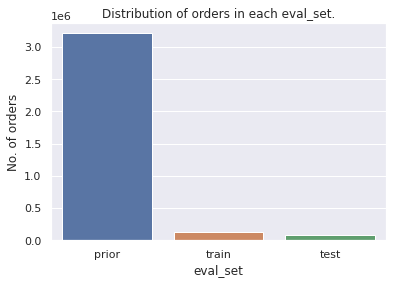

In [ ]:
sns.countplot(x='eval_set',data=orders)
plt.title('Distribution of orders in each eval_set.')
plt.ylabel('No. of orders');

**Coclusion:**
- Prior set has more than 3 million orders.
- Train set has more than 0.1 million orders.
- Eval set has less than 0.1 million orders

#### Q. How many users each set(train/test)?
- CountPlot of no. of users in train and test set.

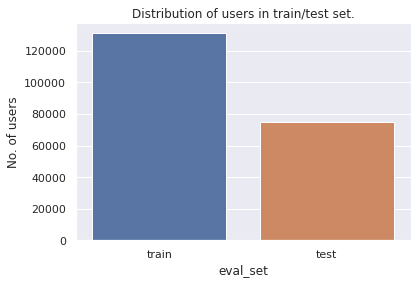

In [ ]:
sns.countplot(x='eval_set',data=orders.loc[~orders.eval_set.str.contains('prior'),:])
plt.title('Distribution of users in train/test set.')
plt.ylabel('No. of users');

**Conclusion:**
- Around 130K users belong to train set.
- Around 75K users belong to test set.

#### Q. How many percent of purchases are first purchase and how many are reorders?
- Piechart

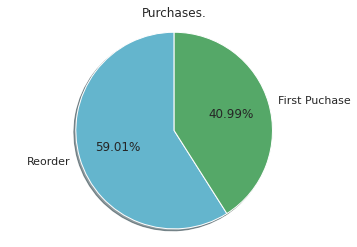

In [ ]:
labels = 'Reorder','First Puchase'

plt.pie(purchase_percent, labels=labels, colors=['c', 'g'],
        startangle=90,
        shadow=True,
        autopct = '%1.2f%%',)

plt.axis('equal')
plt.title('Purchases.');

**Conclusion:**
- There are more reorders than first purchases.

#### Q. How many users placed n number of orders?
- CountPlot of no. of users who place n number of orders.

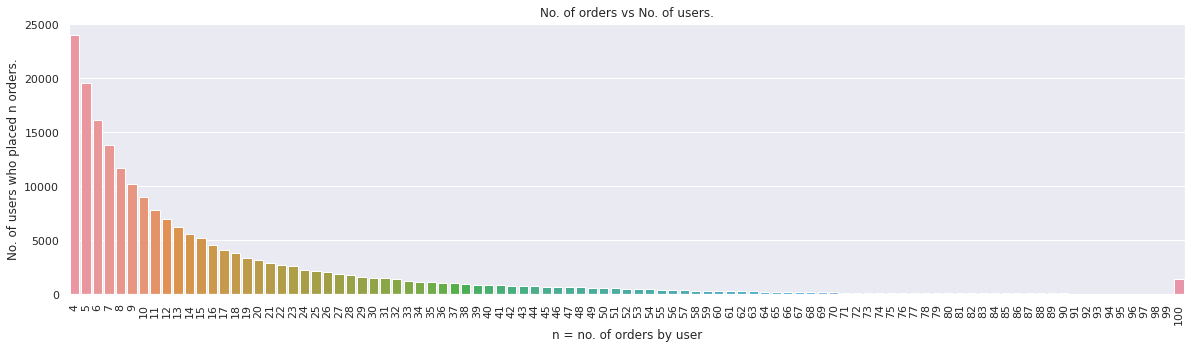

In [ ]:
num_of_orders_per_user = orders.groupby('user_id').size()\
                                .rename('#orders')\
                                .sort_values()\
                                .reset_index()
fig,ax = plt.subplots(figsize=(20,5))
sns.countplot(data=num_of_orders_per_user, x='#orders',ax=ax)
plt.title('No. of orders vs No. of users.')
plt.xlabel('n = no. of orders by user')
plt.ylabel('No. of users who placed n orders.')
plt.xticks(rotation=90);

**Analysis:**
- Each user has placed atleast 4 orders.
- Most users have placed 4-15 orders.
- As the number of orders increase the number of users sharply decrease. There are only a few users who have placed a lot of orders.
- There are some few hundred users who have placed 100 orders. 

> **Conclusion:**
- Each user places between 4-100 orders.
- There is a sharp decrease in number of users as no. of orders increase.

#### Q. How many orders have n number of products?
- CountPlot of number of orders with n number of products.

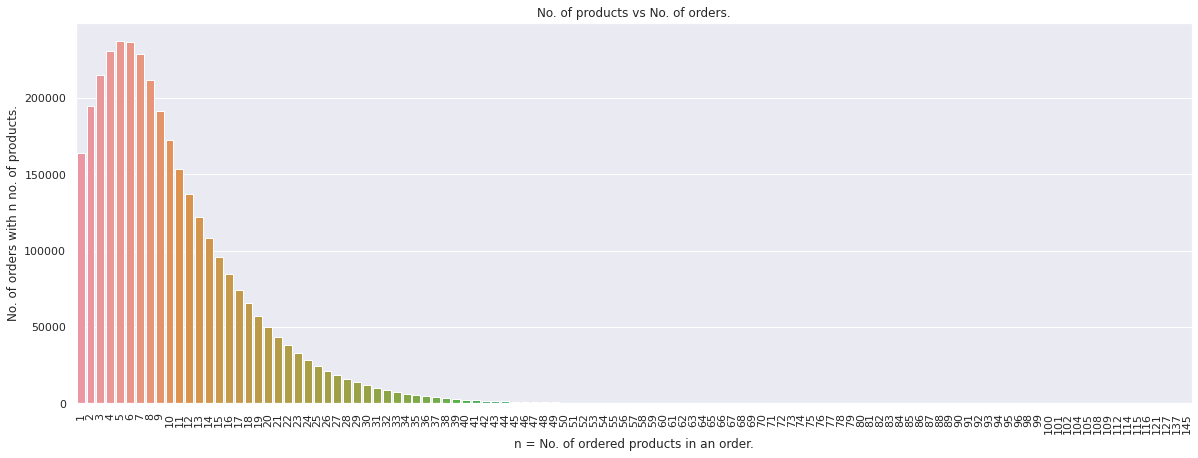

In [ ]:
num_of_prods_per_order = order_products.groupby('order_id').size()\
                                        .rename('#products')\
                                        .sort_values()\
                                        .reset_index()
fig,ax = plt.subplots(figsize=(20,7))
sns.countplot(data=num_of_prods_per_order, x='#products',ax=ax)
plt.title('No. of products vs No. of orders.')
plt.xlabel('n = No. of ordered products in an order.')
plt.ylabel('No. of orders with n no. of products.')
plt.xticks(rotation=90);

**Analysis:**
- An order can have between 1 to 145 products.
- As the number of products in an order increase more than 6 the number orders start decreasing.
- Most orders have 5-6 number of products.
- Orders usually have 1-11 number of products.
- There are almost negligible number of orders with more than 40 products.

> **Conclusion:**
- Customers usually tend to buy less than 20 products in an order.
- Most orders have 5-6 products.

#### Q. How many orders have n number of reordered products?
- Countplot of No. of orders with n no. of reordered products.

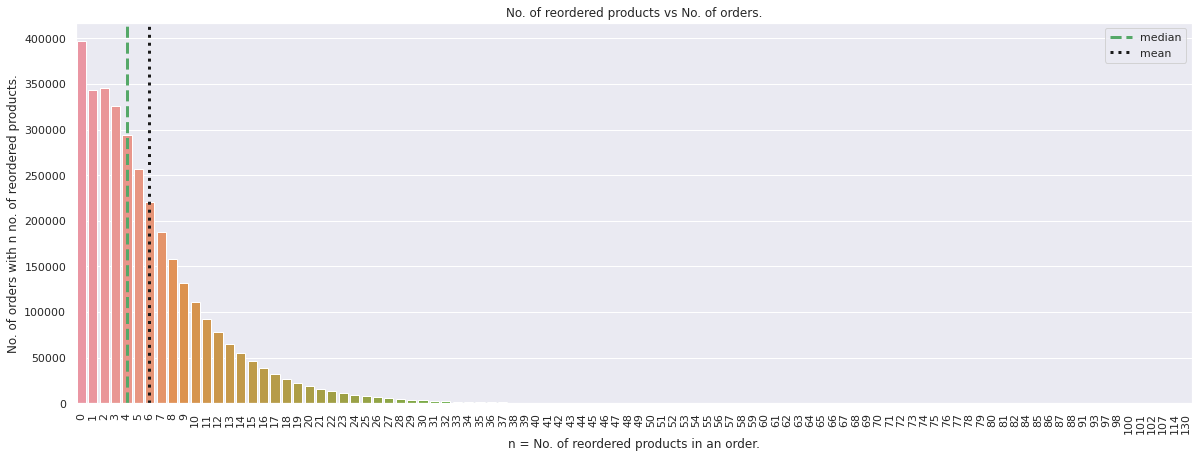

In [ ]:
num_of_reordered_prods_per_order = (
    order_products.groupby('order_id')['reordered'].sum()
                    .rename('#reordered_products')
                    .sort_values()
                    .reset_index()
    )
fig,ax = plt.subplots(figsize=(20,7))
sns.countplot(data=num_of_reordered_prods_per_order,x='#reordered_products',ax=ax,);
plt.axvline(num_of_reordered_prods_per_order['#reordered_products'].median(),ls='--',color='g',lw=3,label='median')
plt.axvline(num_of_reordered_prods_per_order['#reordered_products'].mean(),ls=':',color='k',lw=3,label='mean')
plt.title('No. of reordered products vs No. of orders.')
plt.xlabel('n = No. of reordered products in an order.')
plt.ylabel('No. of orders with n no. of reordered products.')
plt.legend()
plt.xticks(rotation=90);

**Analysis:**
- Since user's 1st order can't have reordered products. There are a lot of orders with zero number of reordered product.
- An order can have between 0-130 number of reordered products.
- As the no. of reordered products in an order increase the no. of orders decrease gradually.
- There are very few orders with more than 25 number of reordered products.
- Average no. of products reordered in an order is around 6.
- Median no. of products reordered in an order is 4.

> **Conclusion:**
- Most customers like to reorder 1-10 products in an order. 

#### Q. What was the distribution of probability of reorder in all orders?
- Histplot of probability of reorder over all orders.

In [ ]:
order_info = data.groupby('order_id')['reordered'].agg(['sum','count','mean'])
order_info.head(3)

,sum,count,mean
order_id,,,
1,4,8,0.500000
2,6,9,0.666667
3,8,8,1.000000


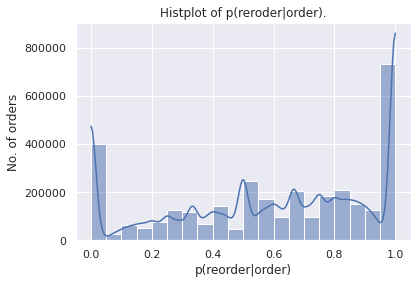

In [ ]:
sns.histplot(data=order_info, x='mean',kde=True,binwidth=0.05,)
plt.xlabel('p(reorder|order)')
plt.ylabel('No. of orders')
plt.title('Histplot of p(reroder|order).');

**Conclusion:**
- Most orders have either all reordered products or None reordered products.
- Lot of None reordered products because first order has 0 reordered products.
- More orders have probability of reorder more than 0.5.

#### Q. How many aisles each department has?
- BarPlot and treemap of distribution of aisles over departments.

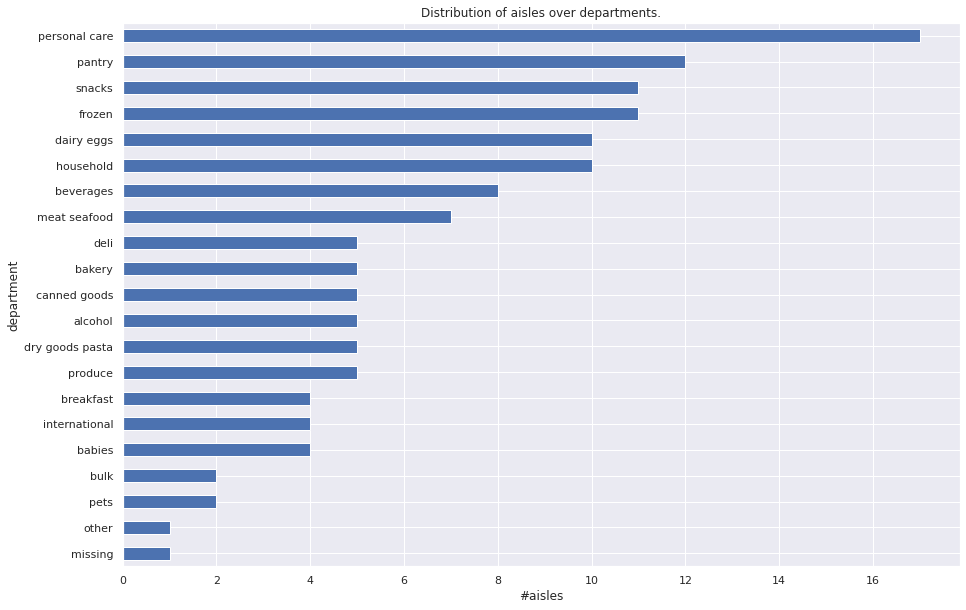

In [ ]:
dep_info = prod_info.drop_duplicates(['department_id','aisle_id'],ignore_index=True)
dep_info.groupby(['department'])['aisle_id'].count().sort_values().plot(kind='barh',
                                                                        figsize=(15,10),
                                                                        grid=True)
plt.xlabel('#aisles')
plt.title('Distribution of aisles over departments.')
plt.show()

In [ ]:
# https://plotly.com/python/treemaps/#
# https://plotly.com/python/reference/treemap/
# https://plotly.com/python-api-reference/generated/plotly.express.treemap
fig = px.treemap(dep_info,
                 path=['department','aisle'],
                 title='Treemap of aisles in each department.',)
fig.update_layout(
    autosize=False,
    width=1050,
    height=1000,)
fig.show()

In [ ]:
# collection of departments with eatable items
eatables_dep = {"pantry","snacks","frozen","dairy eggs","beverages","meat seafood",
                "deli","bakery","canned goods","alcohol","dry goods pasta",
                "produce","breakfast","international","bulk"}
print('These departments contain eatable products:')
print(eatables_dep,'\n')
count = len(dep_info.loc[dep_info.department.apply(lambda row: str(row) in eatables_dep),['department','aisle']])
print("No. of departments with eatable items are :",len(eatables_dep))
print(f"Percentage of departments with eatable items are : {len(eatables_dep)*100/21:.2f}%\n")
print("No. of aisles with eatable items are :",count)
print(f"Percentage of aisles with eatable items are : {count*100/134:.2f}%")

These departments contain eatable products:
{'bakery', 'international', 'deli', 'meat seafood', 'dairy eggs', 'canned goods', 'breakfast', 'frozen', 'produce', 'beverages', 'pantry', 'dry goods pasta', 'snacks', 'alcohol', 'bulk'} 

No. of departments with eatable items are : 15
Percentage of departments with eatable items are : 71.43%

No. of aisles with eatable items are : 99
Percentage of aisles with eatable items are : 73.88%


**Analysis:**
1. Personal care department has the most number of aisles i.e. 17.
2. Departments containing eatable products like pantry, snacks, frozen, dairy eggs, beverages, meat seafood, deli, bakery, canned goods, alcohol, dry goods pasta, produce, breakfast, international & bulk have a total of 99 aisles.
3. missing and other department have only 1 aisle each.

>**Conclusion:**
- Personal Care department has the most number of aisles.
- Eatable items together takes more than 70% of the total aisles and departments present.
- other & missing departments have only one aisle.




#### Q. What is the avg no. of reorders for eatable vs non-eatable products?
- Barplot of avg no. of reorders for eatable and non-eatable.

In [ ]:
# Adding eatables columns in prod_info
prod_info['eatable'] = prod_info.apply(lambda row: row['department'] in eatables_dep,axis=1).astype('uint8')

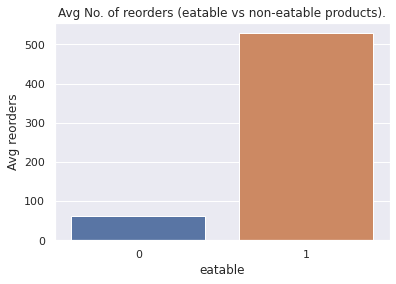

In [ ]:
eatable = order_products.merge(prod_info,on='product_id',how='right')[['product_id','eatable','reordered']]
eatable = eatable.groupby(['eatable','product_id'],as_index=False)['reordered'].sum()
eatable = eatable.groupby('eatable',as_index=False)['reordered'].mean()
sns.barplot(data = eatable, x='eatable',y='reordered',orient='v')
plt.title('Avg No. of reorders (eatable vs non-eatable products).')
plt.ylabel('Avg reorders');
# avg no of reorders in for eatable and non-eatable products.

**Conclusion:**
- Eatable products are far more reordered than non-eatable products.

#### Q. How many products each department has?
- BarPlot of distribution of products over departments.

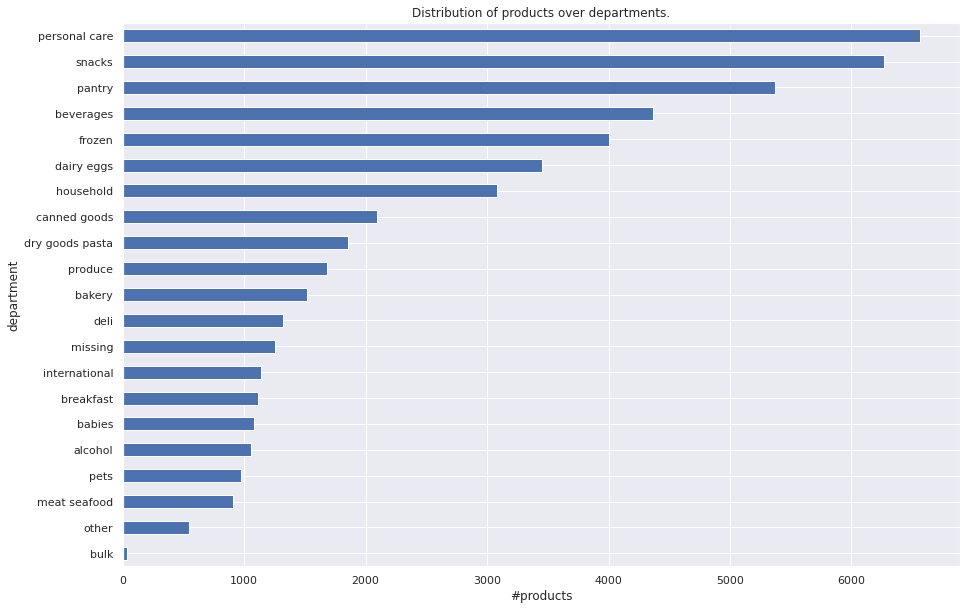

In [ ]:
num_of_prod_per_dep = prod_info.groupby(['department'])['product_id'].count()\
                                .rename('#products_present')

num_of_prod_per_dep.sort_values().plot(kind='barh',
                                        figsize=(15,10),
                                       grid=True)
plt.xlabel('#products')
plt.title('Distribution of products over departments.');

In [ ]:
print("%age of products in eatables department group:")
num_of_prod_per_dep.loc[list(eatables_dep)].sum()*100/num_of_prod_per_dep.sum()

%age of products in eatables department group:


72.81637417485108

**Analysis:**
1. Personal care, snacks, pantry, beverages & frozen departments have almost 27k type of products.
2. Most of the departments with eatable items have a very large variety of products.
2. "bulk" department has only approx 100 types of products.

>**Conclusion:**
- Top 25% of departments contain more than 50% of product variety.
- Eatables departments contain more than 72% types of products.
- bulk department has the least number of products.




#### Q. What is the average no. of reorders per department?
- BarPlot of Avg no. of reorders per department. 

$$ \text{#avg_reorders} = \frac{\sum \text{No. of reorders from the dep.}}{ \text{No. of distinct products in the department}}$$


In [ ]:
dep_info = order_products.merge(prod_info, on='product_id', how='right')\
                .groupby(['department_id','product_id'],as_index=False)\
                ['reordered'].sum()\
                .rename(columns={'reordered':'#reorders'})
dep_info = dep_info.groupby('department_id',as_index=False)\
                    .agg({'#reorders':'mean'})\
                    .rename(columns={'#reorders': '#avg_reorders'})
dep_info = dep.merge(dep_info,on='department_id')             

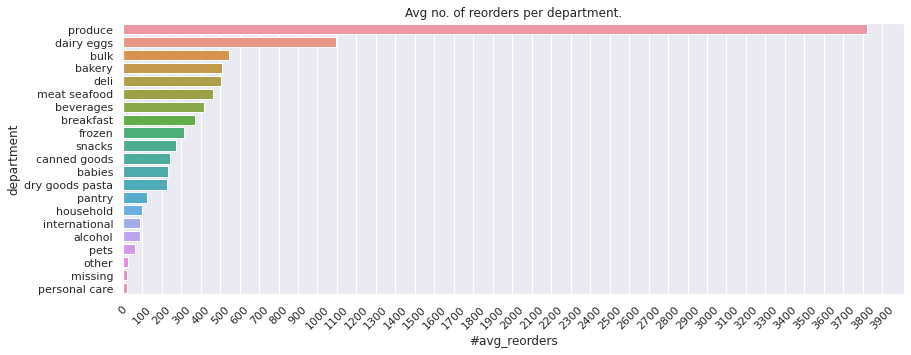

In [ ]:
fig,ax = plt.subplots(figsize=(14,5))
sns.barplot(data=dep_info.sort_values(['#avg_reorders'],ascending=False),
            x='#avg_reorders',
            y='department',
            ax=ax);
plt.xticks(np.arange(0,4000,100),rotation=45)
plt.title('Avg no. of reorders per department.');

**Analysis:**
- All departments with high avg no. of reorders belong to eatable group.
- Produce department alone has a very very high avg no. of reorders.
- Produce and dairy eggs departments combined have more avg no. of reorders than all other departments combined. This could be because Produce and dairy eggs departments contain daily needs products.
- Personal care, other and missing departments have very low avg no. of reorders.

**Conclusion:**
- Produce department's products are highly reordered.
- Personal Care, missing & other departments' products are not reordered much.

#### Q. What is the  probability of reorder of each department?
- BarPlot of p(reorder|department) over each departmnent.

$$\text{p(reorder|department)} = \frac{\text{#reorders from the dep.}}{\text{#purchases from the dep.}} $$

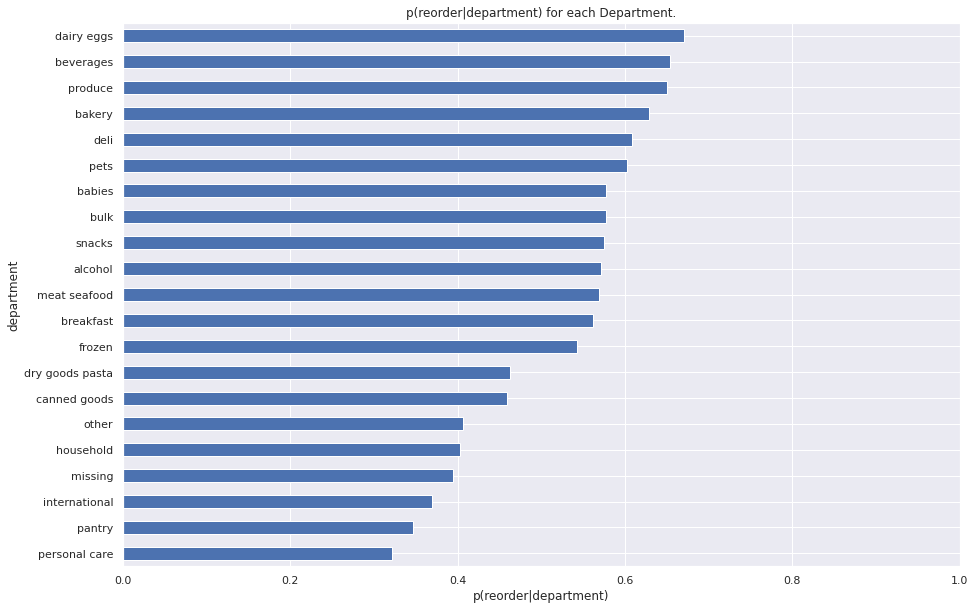

In [ ]:
order_products.merge(prod_info,on='product_id')\
                .groupby(['department'])['reordered'].mean()\
                .sort_values()\
                .plot(kind='barh',
                      figsize=(15,10),
                      grid=True,);
plt.xlabel('p(reorder|department)')
plt.title('p(reorder|department) for each Department.')
plt.xlim(0,1);

**Analysis:**
- All the top departments belong the eatables group.
- Among all "dairy eggs" department has the highest probability of reorder.
- Diary eggs, beverages and produce department are among the top in both sales numbers and probability of reorder.
- Departments having probability of reorder less than 0.5 are disliked by customers because the #reordered products sold is less than #not_reordered products sold.
- canned goods, dry goods pasta, household, international, pantry, Personal care, missing and other departments are disliked by customers.
- Personal care department has a very large variety of products but probability of reorder of this department is very low.

> **Conclusion:**
- Products of dairy eggs, beverages and produce department are very likely to be reordered.
- Products of other, household, missing, international, pantry and Personal care department are very less likely to be reordered.


#### Q. How many products each aisle has?
- Treemap of distribution of products in each aisle.

In [ ]:
fig = px.treemap(prod_info, 
                 path=['department','aisle'],
                 title='Number of products in each (Department, Aisle).')
fig.update_layout(autosize=False,
                width=1050,
                height=1000,)
fig.show();

**Analysis:**
- Some aisle contain more than 1k type of products and some aisle contain only around 50 type of products.
- missing and candy chocolate aisle have the most number of products.
-  packaged produce aisle in produce department has the least number of products
- Almost each department has atleast one aisle which contains more than 500 products.

> **Conclusion:**
- Number of products in each aisle differ a lot.

#### Q. How many products were sold per aisle?
- Treemap of number of products purchased per aisle.

In [ ]:
fig = px.treemap(order_products.merge(prod_info,on='product_id'),
                 path=['department','aisle','reordered'], 
                 title='Number of products sold per (Department, Aisle)')
# changing labels
fig.data[0].labels[fig.data[0].labels=='0']='first_purchase'
fig.data[0].labels[fig.data[0].labels=='1']='reorder'
# resizing figure
fig.update_layout(autosize=False,
                width=1050,
                height=1000,)
fig.show()

**Analysis:**
- Products of almost all aisles have been reordered more than they have been first purchased.
- Fruits, vegetable, eggs and dairy products containing aisles are the bestsellers.
- Pets, missing, other and bulk aisles are the least selling aisles.
- Personal care department sells very less despite having a lot of products, compared to other departments.

> **Conclusion:**
- Natural daily use products like fruits, vegetables, eggs and dairy products are clearly the most popular.
- personal care products are the least popular.




#### Q. What is the average no. of reorders per aisle?
- BarPlot of Avg no. of reorders per aisle. 

$$ \text{#avg_reorders} = \frac{\sum \text{No. of reorders from the aisle}}{ \text{No. of distinct products in the aisle}}$$

In [ ]:
aisle_info = order_products.merge(prod_info, on='product_id', how='right')\
                .groupby(['aisle_id','product_id'],as_index=False)\
                ['reordered'].sum()\
                .rename(columns={'reordered':'#reorders'})
aisle_info = aisle_info.groupby('aisle_id',as_index=False)\
                    .agg({'#reorders':'mean'})\
                    .rename(columns={'#reorders': '#avg_reorders'})
aisle_info = aisles.merge(aisle_info,on='aisle_id')             

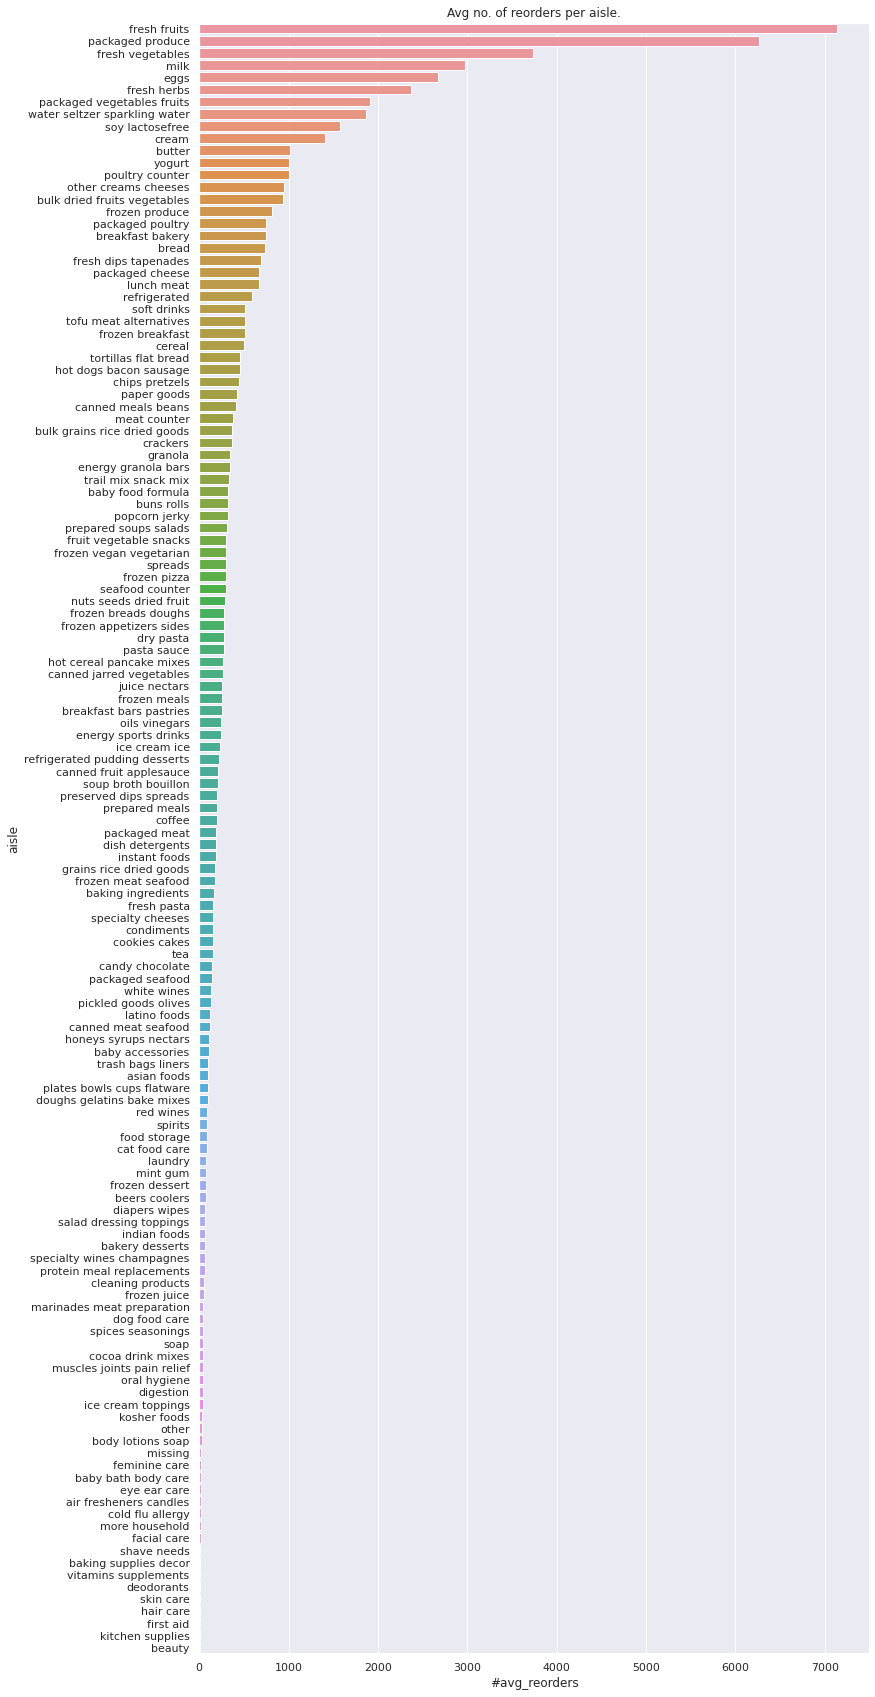

In [ ]:
fig,ax = plt.subplots(figsize=(12,30))
sns.barplot(data=aisle_info.sort_values(['#avg_reorders'],ascending=False),
            x='#avg_reorders',
            y='aisle',
            ax=ax);
#plt.xticks(np.arange(0,4000,100),rotation=45)
plt.title('Avg no. of reorders per aisle.');

**Conclusion:**
- Again the aisles containing the daily needs eatable products have a very high avg no. of reorders than personal care and other type of products.

#### Q. What is the probability of reorder of each aisle?
- BarPlot of p(reorder|aisle) for each aisle.

$$\text{p(reorder|aisle)} = \frac{\text{#reorders from the aisle}}{\text{#purchases from the aisle}} $$

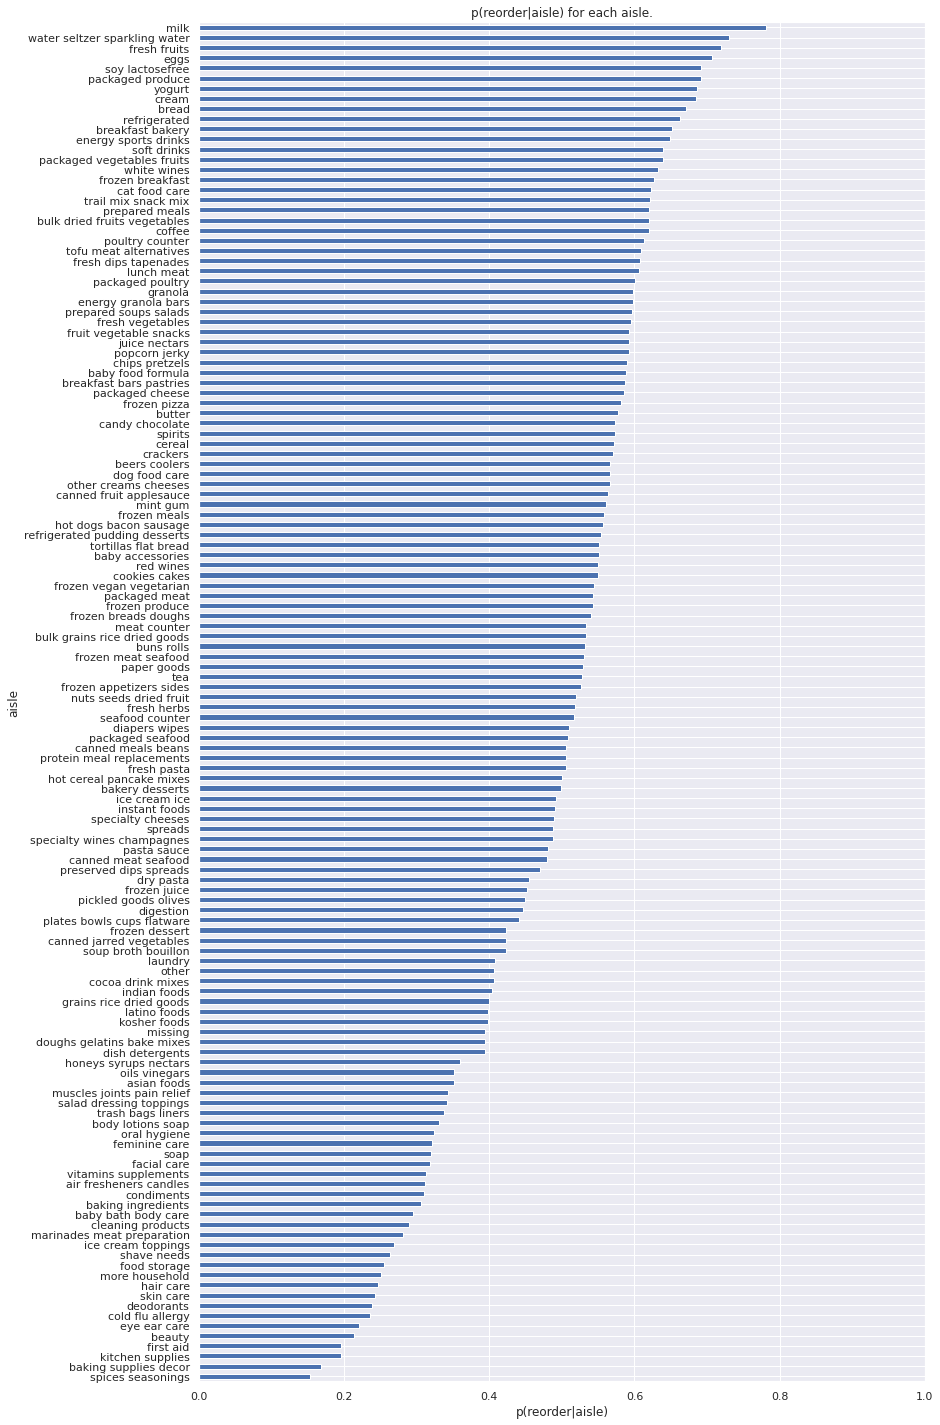

In [ ]:
order_products.merge(prod_info,on='product_id')\
                .groupby(['aisle'])['reordered'].mean()\
                .sort_values()\
                .plot(kind='barh',
                      figsize=(13,25),
                      grid=True,);
plt.xlabel('p(reorder|aisle)')
plt.title('p(reorder|aisle) for each aisle.')
plt.xlim(0,1);

**Analysis:**
- Dairy products containing aisles like milk, eggs, yogurt etc. have a very high probability of reorder.
- water seltzer sparkling water aisle also has a very high prob of rerorder.
- Again personal care aisles are at the bottom.
- The probability of reorder lies roughly in the range of 0.17 - 0.78

**Conclusion:**
- Dairy products containing aisles have very high probability of reorder.

#### Q. How many orders were placed over each day of week?
- CountPlot of number of orders over each order_dow(day of week).

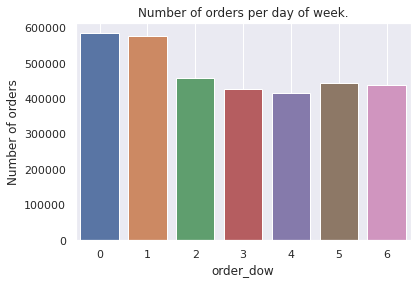

In [ ]:
sns.countplot(x='order_dow',data=orders.loc[orders.eval_set.astype(str)!='test',:])
plt.title('Number of orders per day of week.')
plt.ylabel('Number of orders')
plt.grid()
plt.show()

**Analysis:**
- There are a lot more number of orders on day 0 and 1 than on other days.
- After Day 1 the number of orders keep decreasing till day 4 and then it rises.

> **Conclusion:**
- Day 0 and 1 of week are the most popular of purchasing.

#### Q. How many products are sold over each day of week?
- CountPlot of no. of Products sold over each order_dow.

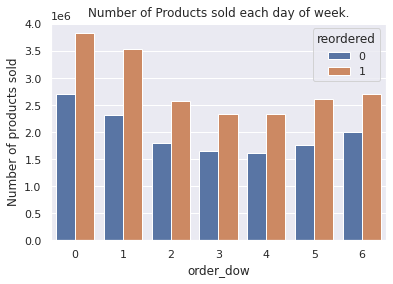

In [ ]:
sns.countplot(x='order_dow',hue='reordered',data=data)
plt.ylabel('Number of products sold')
plt.title('Number of Products sold each day of week.');

**Analysis:**
- Most number of products are ordered and reordered on Day 0.
- After Day 0 the number of products sold keep decreasing till day 3-4 and then it increases.
- The number of products reordered are always more than the the number of products not reordered, on a given day.

**Conclusion:**
- The number of reorders clearly changes with day of week, with the first two days being most popular for purchasing products.


#### Q. What is the probability of reorder on each day of week?

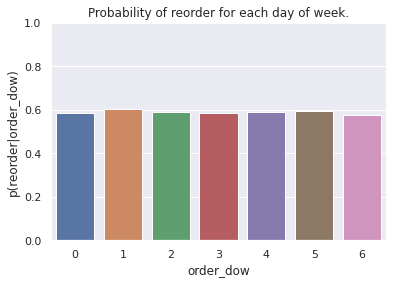

In [ ]:
sns.barplot(x='order_dow',y='reordered',data=data, estimator=np.mean, orient='v')
plt.ylabel('p(reorder|order_dow)')
plt.title('Probability of reorder for each day of week.')
plt.ylim(0,1);

**Conclusion:**
- The probability of reorder remains more or less the same on all days.

#### Q. How many products are sold each hour of day?
- CountPlot of Number of products sold each hour of day.

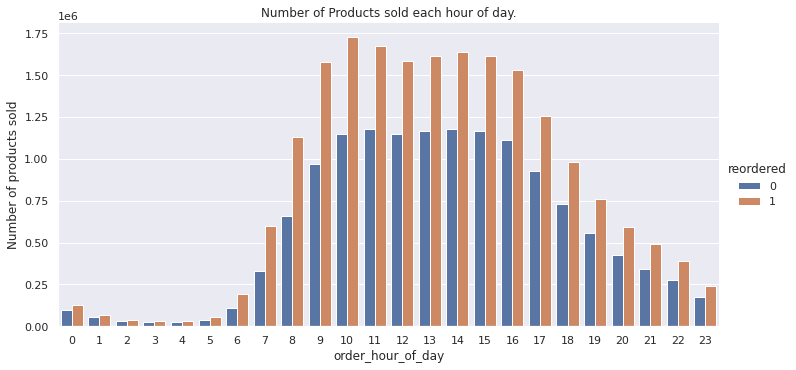

In [ ]:
sns.catplot(x='order_hour_of_day',hue='reordered',data=data,kind='count',aspect=2)
plt.ylabel('Number of products sold')
plt.title('Number of Products sold each hour of day.');

**Analysis:**
- The number of products ordered during the first six hours(0-5) of a day is very low.
- After that, from the 6th hour the number of products ordered kept increasing till the 10th hour.
- After the 10th hour there is a little decrease in sales but more or less it stays the same till the 16th hour.
- After the 16th hour there is sudden decrease in the number of prouduts ordered. And, it keep decreasing till the last 23rd hour.
- Looking at the pattern, it looks like 0-5 is after midnight time, 6-11 is morining time, 12-17 is afternoon time and 18-23 is night time.

> **Conclusion:**
- The number of reorders clearly changes with time of day.
- morning and afternoon are the most suitable times for customer orders.


#### Q. What is the probability of reorder at each hour of day?

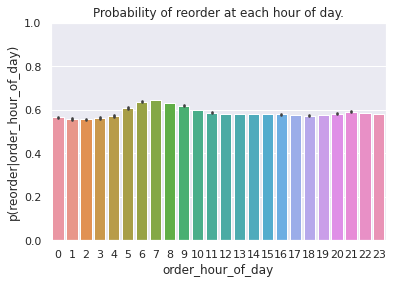

In [ ]:
sns.barplot(x='order_hour_of_day',
            y='reordered',
            data=data,
            estimator=np.mean,
            orient='v')
plt.ylabel('p(reorder|order_hour_of_day)')
plt.title('Probability of reorder at each hour of day.')
plt.ylim(0,1);

**Conclusion:**
- The probability of reorder remains same whole day, except in the morning(5-11) when the probability is high.

#### Q. How many products are reordered on each day of week and at each hour of day?
- Heatmap of no. of reorders at each hour_of_day of each dow.

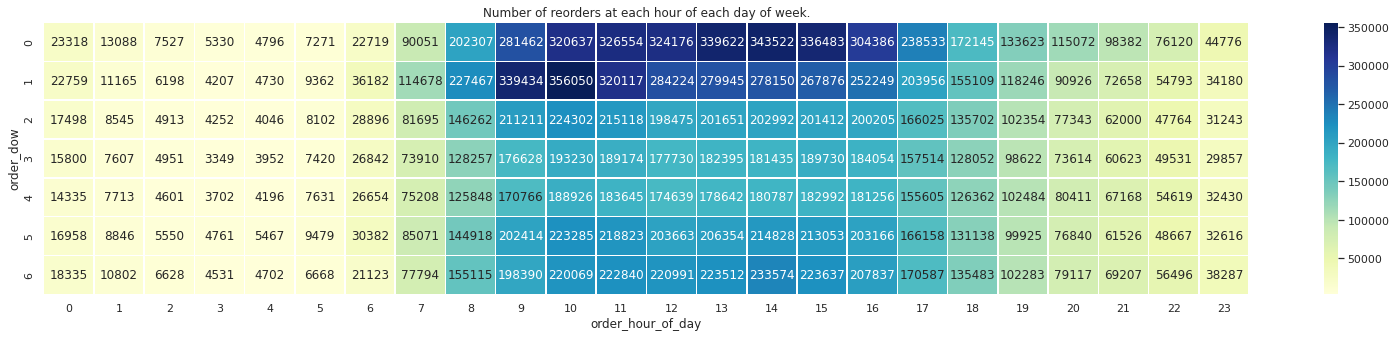

In [ ]:
no_of_reorders_at_time = data.pivot_table(values='reordered',
                                          index='order_dow',
                                          columns='order_hour_of_day',
                                          aggfunc=sum)\
                                          .astype('int64')
fig, ax = plt.subplots(figsize=(27,5))
sns.heatmap(no_of_reorders_at_time,annot=True,fmt='d',linewidth=.5,cmap="YlGnBu",ax=ax)
plt.title('Number of reorders at each hour of each day of week.');

**Analysis:**
- Customers love to reorder on day 0 & 1 of week between the 8th and 17th hour of day.
- After that, the 2nd most popular slot is on day 2-6 of week between the 8th and 17th hour of day.
- There are very few reorders on each day between the 2nd and 5th hour.

> **Conclusion:**
- Number 1 slot for reordering products is on day 0-1 of week between 8th and 17th hour of day.

#### Q. Which are the popular products, departments and aisle at each instant of time?

In [ ]:
def popular_pda(df,dep_info,aisle_info):
    ''' Returns Series containing product, department
    and aisle which are the most popular.'''
    # popular product
    prod = df.groupby('product_name')['reordered'].sum().idxmax()

    # popular department
    dept = df.groupby('department')['reordered'].sum()
    dept = dep_info.merge(dept,left_index=True,right_index=True)
    dept['#reorders'] = dept['reordered']/dep_info['#products']
    pop_dep = dept['#reorders'].idxmax()
    
    # popular aisle
    aisle = df.groupby('aisle')['reordered'].sum()
    aisle = aisle_info.merge(aisle,left_index=True,right_index=True)
    aisle['#reorders'] = aisle['reordered']/aisle_info['#products']
    pop_aisle = aisle['#reorders'].idxmax()

    # output
    out = pd.Series(data=[prod,pop_dep,pop_aisle],
                    index=['popular_product','popular_dep','popular_aisle'])
    return out

In [ ]:
aisle_info = prod_info.groupby('aisle')['product_id'].count().to_frame('#products')
dep_info = prod_info.groupby('department')['product_id'].count().to_frame('#products')
pop = data.merge(prod_info,on='product_id')\
        .groupby(['order_dow','order_hour_of_day'],as_index=False)\
        [['product_name','department','aisle','reordered']]\
        .apply(popular_pda,dep_info,aisle_info)

In [ ]:
pop = pop.pivot(index='order_dow',columns='order_hour_of_day')

In [ ]:
# popular product at each instant of time
pop['popular_product']

order_hour_of_day,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
order_dow,,,,,,,,,,,,,,,,,,,,,,,,
0,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana
1,Bag of Organic Banana,Banana,Banana,Bag of Organic Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana
2,Bag of Organic Banana,Bag of Organic Banana,Bag of Organic Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana
3,Banana,Bag of Organic Banana,Bag of Organic Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Bag of Organic Banana
4,Banana,Bag of Organic Banana,Banana,Banana,Bag of Organic Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana
5,Banana,Bag of Organic Banana,Banana,Bag of Organic Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana
6,Banana,Bag of Organic Banana,Bag of Organic Banana,Banana,Bag of Organic Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana


In [ ]:
# popular department at each instant of time
pop['popular_dep']

order_hour_of_day,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
order_dow,,,,,,,,,,,,,,,,,,,,,,,,
0,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce
1,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce
2,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce
3,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce
4,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce
5,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce
6,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce


In [ ]:
# popular aisle at each instant of time
pop['popular_aisle']

order_hour_of_day,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
order_dow,,,,,,,,,,,,,,,,,,,,,,,,
0,fresh fruits,packaged produce,fresh fruits,fresh fruits,packaged produce,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,packaged produce
1,fresh fruits,packaged produce,packaged produce,packaged produce,packaged produce,packaged produce,fresh fruits,packaged produce,packaged produce,packaged produce,packaged produce,packaged produce,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,packaged produce,fresh fruits
2,packaged produce,fresh fruits,packaged produce,packaged produce,packaged produce,packaged produce,fresh fruits,packaged produce,packaged produce,packaged produce,packaged produce,packaged produce,packaged produce,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,packaged produce,packaged produce,packaged produce
3,packaged produce,packaged produce,packaged produce,packaged produce,fresh fruits,packaged produce,packaged produce,fresh fruits,packaged produce,packaged produce,packaged produce,packaged produce,packaged produce,packaged produce,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,packaged produce,packaged produce,packaged produce
4,packaged produce,packaged produce,fresh fruits,fresh fruits,packaged produce,packaged produce,packaged produce,packaged produce,packaged produce,packaged produce,packaged produce,packaged produce,packaged produce,packaged produce,packaged produce,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,packaged produce
5,packaged produce,packaged produce,fresh fruits,packaged produce,packaged produce,packaged produce,packaged produce,fresh fruits,packaged produce,packaged produce,packaged produce,packaged produce,packaged produce,packaged produce,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits
6,fresh fruits,fresh fruits,packaged produce,packaged produce,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits


**Conclusion:**
- Bananas are very much popular at each instant of time.
- During midnight people prefer to Bag of Bananas.
- Produce department is very much popular at each instant of time.
- On day 0 and day 6, fresh fruits aisle is very popular.
- At 14-20 hrs, fresh fruits aisle is very much popular.
- Remaining time, packaged produce is very famous.

#### Q. How many products are sold after a gap of certain number of days in customer's order?
- CountPlot of no. of products ordered for day_since_prior_order.

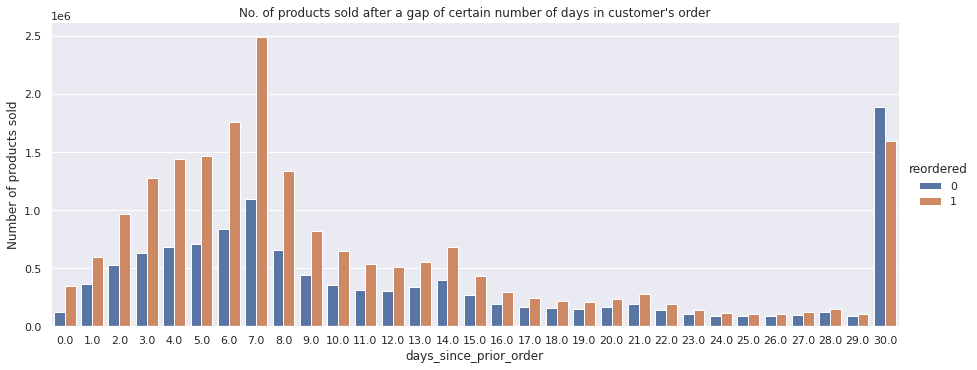

In [ ]:
sns.catplot(x='days_since_prior_order',hue='reordered',data=data,kind='count',aspect=2.5)
plt.ylabel('Number of products sold')
plt.title("No. of products sold after a gap of certain number of days in customer's order");

**Analysis:**
- When customers come the same day again, they tend to buy reordered products a lot more than not reordered products.
- Most customers love to come again on a weekly basis(weekly customers).
- The customers who come again on a weekly basis reorder more than double, than buying the new products for the first time.
- There is a sudden decrease in the number of products sold for customers who come after a gap of 8-13 days. But after a gap of 14 days sales increase. This means there are some customers who love to come after 2 weeks(bi-weekly customers).
- Similarly there are some customers who prefer shopping after 3 weeks(tri-weekly customers).
- There are a lot of customers who love to come on a monthly basis(monthly customers) and they buy new products more.

> **Conclusion:**
- Products sold for customers who come after 0 to 15 day are mostly reorders.
- Customer who come after every week reorder a lot.
- Customers try new products more on mothly basis.


#### Q. What is the probability of reorder for days_since_prior_order?
- BarPlot of probability of reorder for each days_since_prior_order.

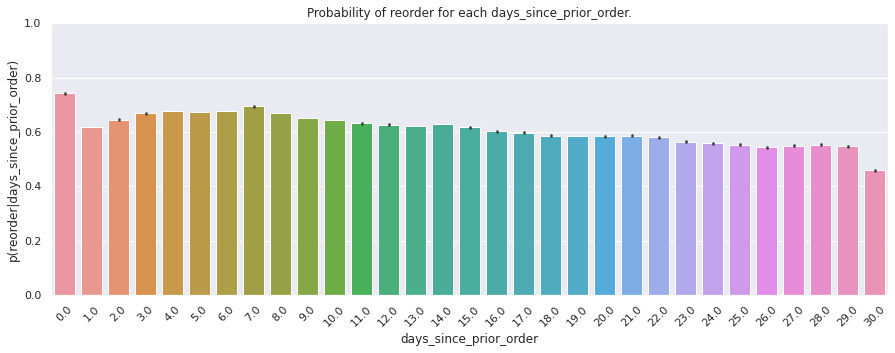

In [ ]:
fig,ax = plt.subplots(figsize=(15,5))
sns.barplot(x='days_since_prior_order',
            y='reordered',
            data=data,
            estimator=np.mean,
            orient='v',
            ax=ax)
plt.ylabel('p(reorder|days_since_prior_order)')
plt.title('Probability of reorder for each days_since_prior_order.')
plt.xticks(rotation=45)
plt.ylim(0,1,);

**Analysis:**
- As days since prior order gets more than 7, then customers tend to reorder less in comparison to buying new products.
- When customers come the same day again, they reorder a lot.
- When customers come one month later, they reorder less.

**Conclusion:**
- 

#### Exploring weekly and monthly customers.

In [ ]:
user_train = orders.loc[orders['eval_set'].str.contains('train'), ['user_id']]
user_train = orders.merge(user_train, on='user_id').groupby('user_id')\
                    ['days_since_prior_order'].agg(['mean'])\
                    .reset_index()

# weekly customer: customers whose avg days_since_prior_order is between 6-8
weekly_user = user_train.loc[user_train['mean'].between(6,8),['user_id']]

# monthly customer: customers whose avg days_since_prior_order is between 28-30
monthly_user = user_train.loc[(user_train['mean'].between(28,30)), ['user_id']]
del user_train

##### Count of each type of customer.

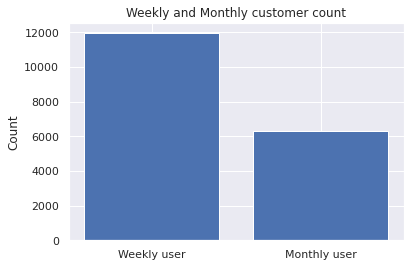

In [ ]:
plt.bar(['Weekly user','Monthly user'],[len(weekly_user),len(monthly_user)])
plt.ylabel('Count')
plt.title('Weekly and Monthly customer count');

**Analysis:**
- No. of weekly customers are almost double the no. of monthly customers.

##### How many purchases are made by both type of customers at each hour_of_day?
- CountPlot of purchases at each hour_of_day.

In [ ]:
weekly_user = data[['user_id','order_hour_of_day','order_dow','product_id','reordered']]\
                    .merge(weekly_user, on='user_id')
monthly_user = data[['user_id','order_hour_of_day','order_dow','product_id','reordered']]\
                    .merge(monthly_user, on='user_id')

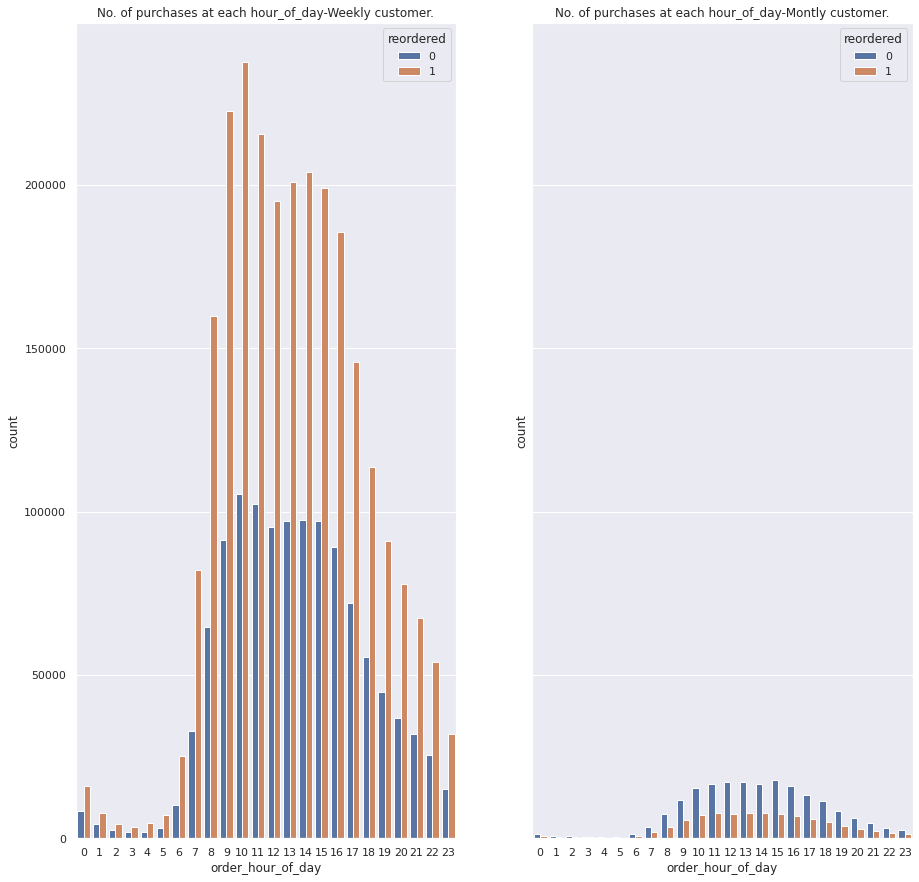

In [ ]:
fig,(ax1,ax2) = plt.subplots(ncols=2,figsize=(15,15),sharey=True)
sns.countplot(data=weekly_user,x='order_hour_of_day', hue='reordered',ax=ax1);
sns.countplot(data=monthly_user,x='order_hour_of_day', hue='reordered',ax=ax2);
ax1.set_title('No. of purchases at each hour_of_day-Weekly customer.')
ax2.set_title('No. of purchases at each hour_of_day-Montly customer.');

**Analysis:**
- The no. of purchases by weekly customers are significantly more than that of the monthly customers.
- Weekly customers reorder more than buying new product.
- Monthly customers reorder less and buy new products more.
- The pattern of the graph is almost same for both type of customers i.e. both purchase very less after midnight, then the purchase increases in the morning and then it decreases at night.

##### What is the probability of reorder of both customers at each hour_of_day?
- BarPlot of probability of reorder at each hour of day.

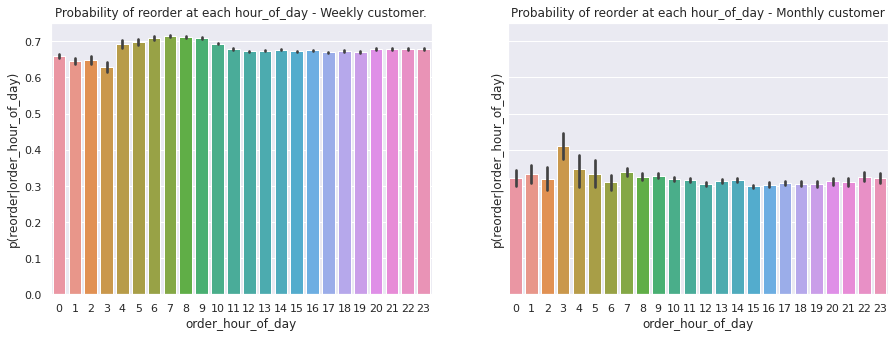

In [ ]:
fig,(ax1,ax2) = plt.subplots(ncols=2,figsize=(15,5),sharey=True)
sns.barplot(data=weekly_user, x='order_hour_of_day',y='reordered',ax=ax1)
sns.barplot(data=monthly_user, x='order_hour_of_day',y='reordered',ax=ax2)
ax1.set_ylabel('p(reorder|order_hour_of_day)')
ax2.set_ylabel('p(reorder|order_hour_of_day)');
ax1.set_title('Probability of reorder at each hour_of_day - Weekly customer.')
ax2.set_title('Probability of reorder at each hour_of_day - Monthly customer');

**Analysis:**
- Probability of reorder of weekly customers is significantly larger than that of monthly customer.

##### How many purchases are made by both type of customers at each day_of_week?
- CountPlot of no. of purchases at each day_of_week.

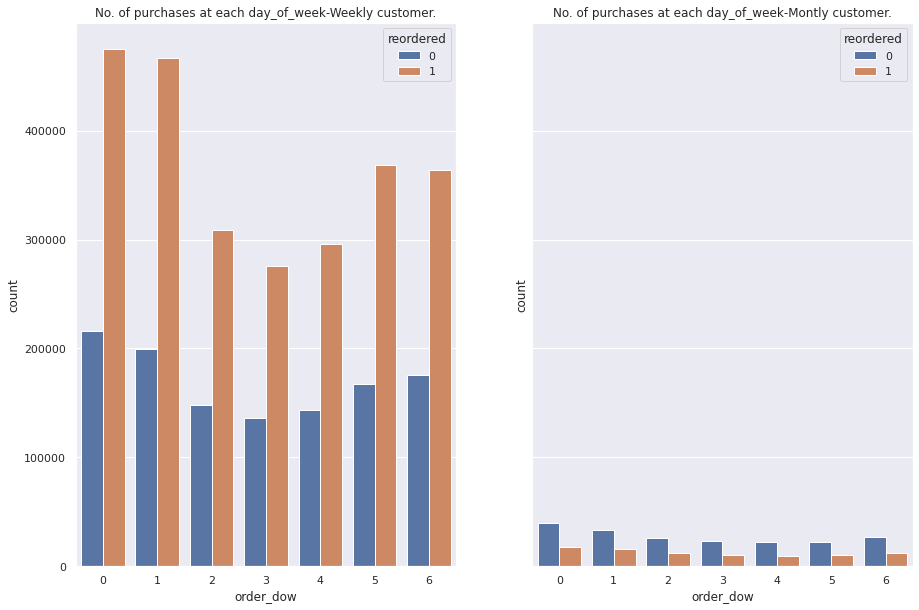

In [ ]:
fig,(ax1,ax2) = plt.subplots(ncols=2,figsize=(15,10),sharey=True)
sns.countplot(data=weekly_user,x='order_dow', hue='reordered',ax=ax1);
sns.countplot(data=monthly_user,x='order_dow', hue='reordered',ax=ax2);
ax1.set_title('No. of purchases at each day_of_week-Weekly customer.')
ax2.set_title('No. of purchases at each day_of_week-Montly customer.');

**Analysis:**
- Here again the pattern of both graphs is same i.e. both purchase more at the start of the week and then it decreases mid-week and again increases during weekend.

##### What is the probability of reorder of both customers at each day_of_week?
- BarPlot of probability of reorder at day_of_week.

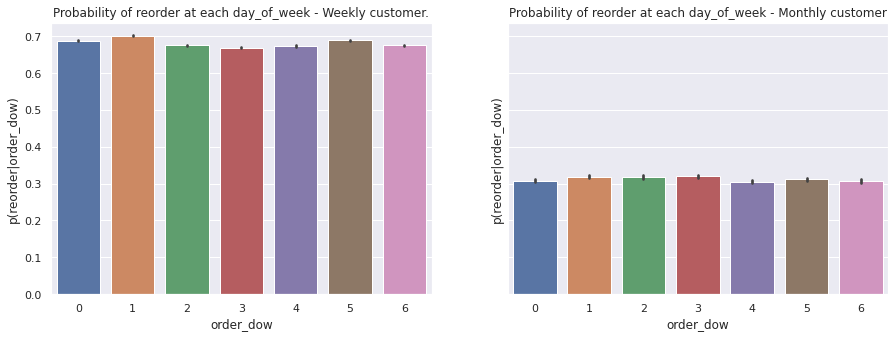

In [ ]:
fig,(ax1,ax2) = plt.subplots(ncols=2,figsize=(15,5),sharey=True)
sns.barplot(data=weekly_user, x='order_dow',y='reordered',ax=ax1)
sns.barplot(data=monthly_user, x='order_dow',y='reordered',ax=ax2);
ax1.set_ylabel('p(reorder|order_dow)')
ax2.set_ylabel('p(reorder|order_dow)');
ax1.set_title('Probability of reorder at each day_of_week - Weekly customer.')
ax2.set_title('Probability of reorder at each day_of_week - Monthly customer');

**Analysis:**
- Here also the probability of reorder at each day_of_week is significantly larger for weekly customers.
- The probability for both type of customers remain more or less the constant at each day_of_week.

**Conclusion:**
- More monthly customers than weekly customers.
- Weekly customers purchase a lot more than the monthly customers.
- Weekly customers reorder more and monthly customers purchase new products more.

#### Q. How many products are sold in customer's nth order?
- CountPlot of number of products sold for each order_number

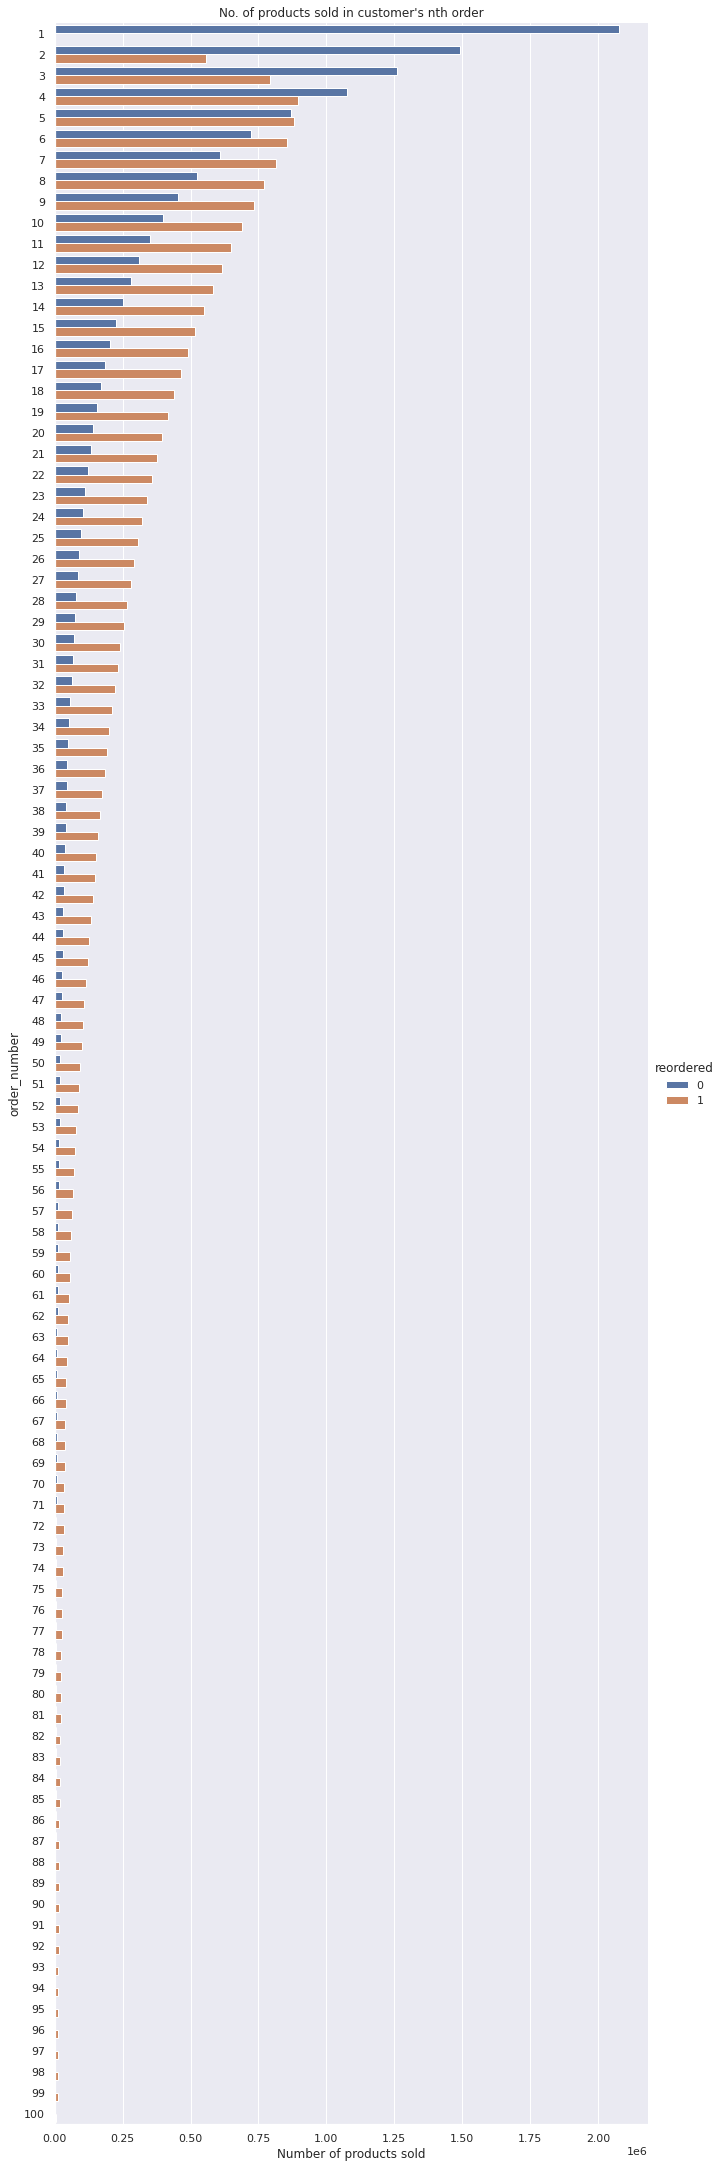

In [ ]:
sns.catplot(y='order_number',hue='reordered',data=data,kind='count',height=30,aspect=0.3)
plt.xlabel('Number of products sold')
plt.title("No. of products sold in customer's nth order");

**Analysis:**
- Number of products ordered decreases as the order_number increases. This is quite obvious as new and new customers join they place their first initial orders hence leading to more product sales for initial order numbers.

> **Conclusion:**
- No. of reordered products decreases with the increase in order number.

#### Q. What is the average no. of reordered products in a order for each order_number? 
- Barplot of avg no. of reorders for each order_number.
$$\text{#avg_reorders} = \frac{\text{#reorders for a order_number}}{\text{#order_ids for that order_number}} $$

In [ ]:
order_no_vs_reorder = data.groupby(['order_id','order_number'],
                                as_index=False)\
                                ['reordered'].sum()\
                                .rename(columns={'reordered':'#reorders'})
order_no_vs_reorder = order_no_vs_reorder.groupby('order_number',as_index=False)\
                                    ['#reorders'].mean()\
                                    .rename(columns={'#reorders':'#avg_reorders'})

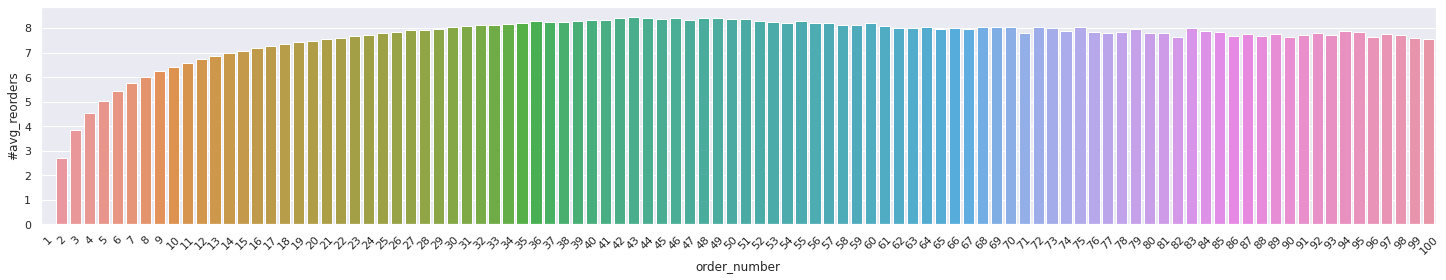

In [ ]:
fig,ax = plt.subplots(figsize=(25,4))
sns.barplot(data=order_no_vs_reorder,x='order_number',y='#avg_reorders',orient='v',ax=ax)
plt.title('Average no. of reorders per order_number.')
plt.xticks(rotation=45);

**Analysis:**
- Obviously, for order_number=1 there is are no reorders.
- The #avg_reorders keep increasing till order_number 43 and then it decreases very slowly.

**Conclusion:**
- The #avg_reorders is very low in the first few orders, then it increases sharply and then it saturates and then it again falls very slowly.

#### Q. What is the probability of reorder for each order_number?
- BarPlot of probability of reorder for each order_number.

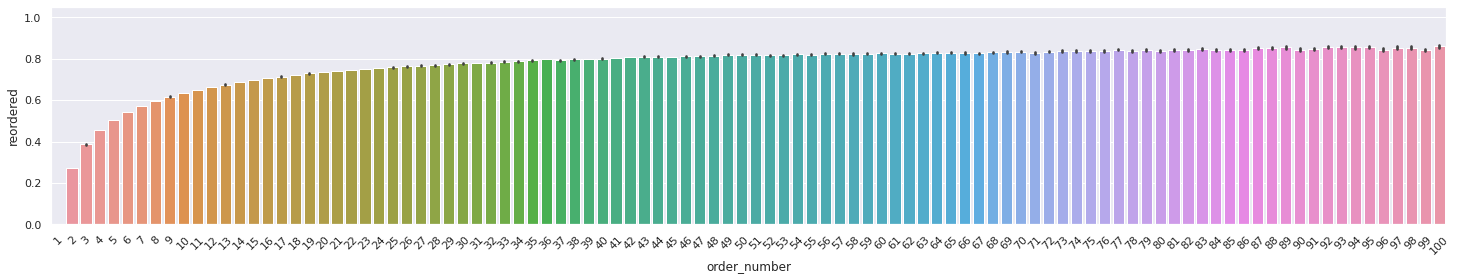

In [ ]:
fig,ax = plt.subplots(figsize=(25,4))
sns.barplot(data=data,x='order_number',y='reordered',estimator=np.mean,orient='v',ax=ax)
plt.ylabel('p(reorder|order_number')
plt.title('Probability of reorder for each order_number.')
plt.xticks(rotation=45)
plt.ylim(0,1.05);

**Conclusion:**
- Probability of reorder sharply increases in starting orders and then it gradually increases till the end.

#### Q. How many products are first_purchased or reordered at nth add_to_cart_value.
- BarPlot of reorders and first_purchases for each add_to_cart_value.

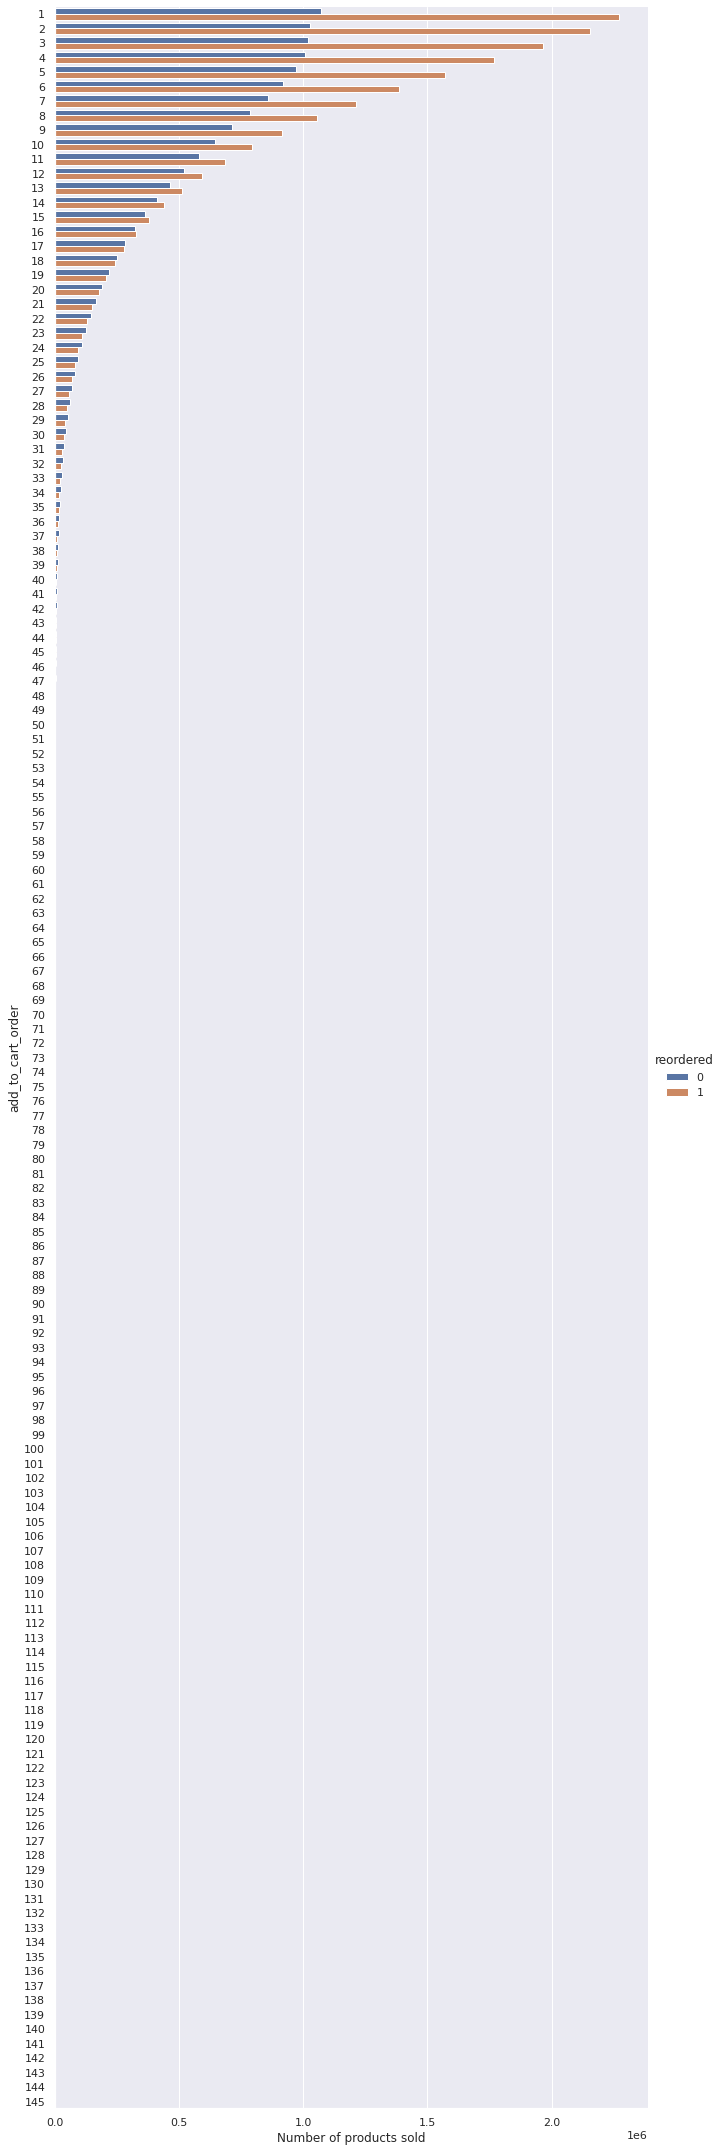

In [ ]:
sns.catplot(y='add_to_cart_order',
            hue='reordered',
            data=data,
            kind='count',
            height=30,
            aspect=0.3)
plt.xlabel('Number of products sold')
plt.title('First_Purchases and Reorders at each add_to_cart_value.')
plt.show()

**Analysis:**
- Mostly customers put that product in the cart first which is a reorder and as the add_to_cart_order increases there are more chances of customer putting new products in the cart.

> **Conclusion:**
- As the add_to_cart_order increases the no. of first_purchases and no. of reorders decreases.
- The decrease in no. of reorders is more sharp.

#### Q. What is the probability of reorder for each add_to_cart_order value?
- BarPlot of probability of reorder for each add_to_cart_order value.

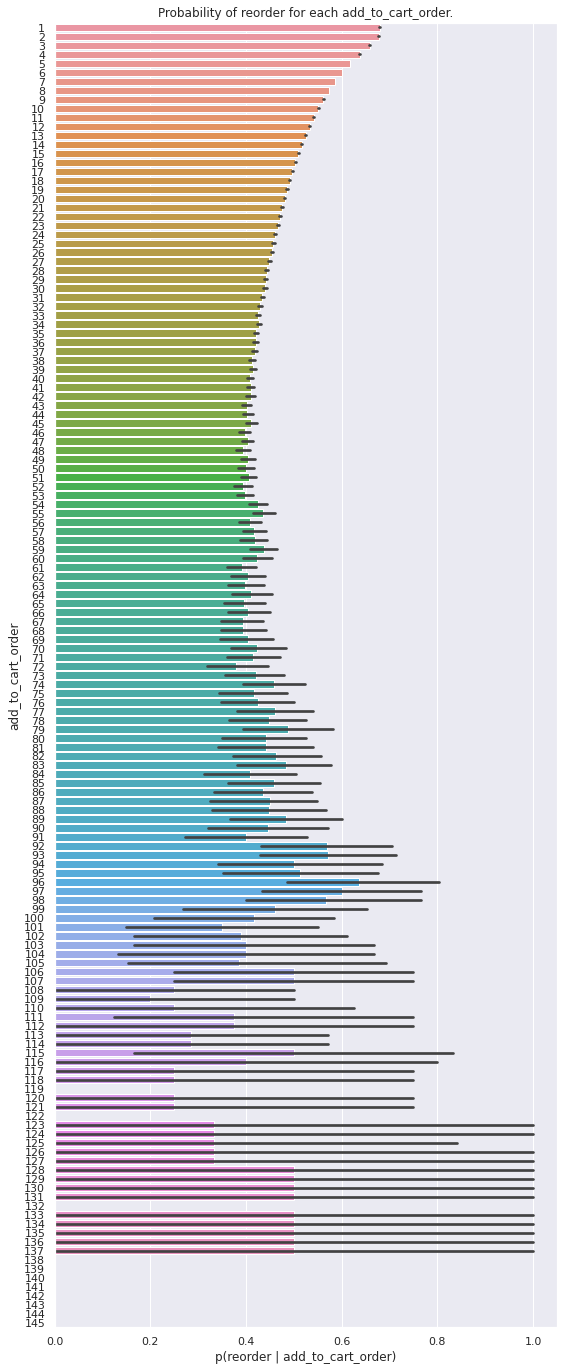

In [ ]:
fig,ax = plt.subplots(figsize=(9,24))
sns.barplot(data=data,
            y='add_to_cart_order',
            x='reordered',
            estimator=np.mean,
            orient='h',
            n_boot=500,
            ax=ax)
plt.title('Probability of reorder for each add_to_cart_order.')
plt.xlabel('p(reorder | add_to_cart_order)');

**Conclusion:**
- The probability of reorder decreases as the add_to_cart_order of products increases.
- The probabilty of reorder of large order_numbers cannot be inferred from the above plot as they have very large confidence intervals. This could be because there are very few orders having large order_numbers.

#### Q. How many products have n=add_to_cart_order place in a order?
- Histogram of no. of products in each add_to_cart_order

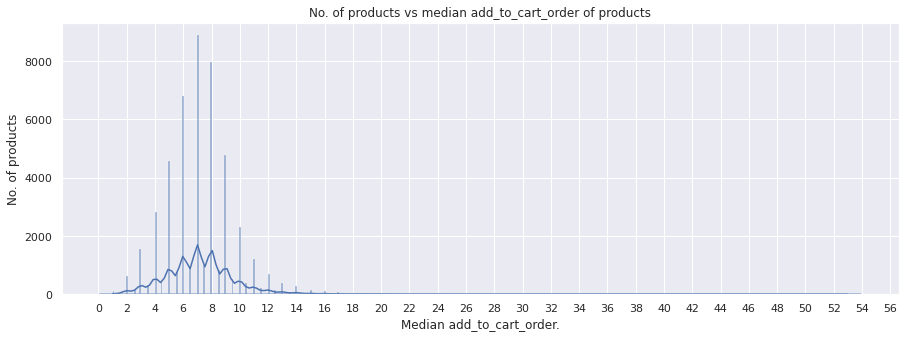

In [ ]:
fig,ax = plt.subplots(figsize=(15,5))
sns.histplot(order_products.groupby('product_id')['add_to_cart_order'].median(),kde=True,ax=ax);
sns.kdeplot(order_products.groupby('product_id')['add_to_cart_order'].median(),ax=ax);
plt.ylabel('No. of products')
plt.xlabel('Median add_to_cart_order.')
plt.title('No. of products vs median add_to_cart_order of products')
plt.xticks(np.arange(0,58,2));

**Conclusion:**
- Most products have their median add_to_cart_order between 2 to 12. As we saw earlier that most orders have around 1-11 products. This could be the reason behind this graph.
- Some products have large(i.e. greater than 12) 

#### Q. What is the probability of reordering a product?
- PDF of p(reorder|product)

In [ ]:
num_of_times_product_ordered = order_products.merge(prod_info, on='product_id',how='right')\
                                            .groupby('product_id')['reordered'].count()\
                                            .rename('#times_ordered')\
                                            .reset_index()
num_of_times_product_reordered = order_products.merge(prod_info, on='product_id',how='right')\
                                            .groupby('product_id')['reordered'].sum()\
                                            .rename('#times_reordered')\
                                            .reset_index()\
                                            .astype({'#times_reordered':'int64'})

In [ ]:
prod_info = prod_info.merge(num_of_times_product_ordered,on='product_id',how='left')
prod_info = prod_info.merge(num_of_times_product_reordered,on='product_id',how='left')

In [ ]:
# probability of reorder of a product = (number of times reordered / number of times ordered)
prod_info['p(reorder|product)'] = prod_info.apply(lambda row: row['#times_reordered']/row['#times_ordered'] if (row['#times_ordered']!=0) else 0.0,axis='columns')
prod_info['#first_purchase'] = prod_info['#times_ordered'] - prod_info['#times_reordered']

In [ ]:
prod_info.head()

,product_id,product_name,aisle_id,department_id,department,aisle,eatable,#times_ordered,#times_reordered,p(reorder|product),#first_purchase
0,1,Chocolate Sandwich Cookies,61,19,snacks,cookies cakes,1,1928,1185,0.614627,743
1,78,Nutter Butter Cookie Bites Go-Pak,61,19,snacks,cookies cakes,1,12,4,0.333333,8
2,102,Danish Butter Cookies,61,19,snacks,cookies cakes,1,190,37,0.194737,153
3,172,Gluten Free All Natural Chocolate Chip Cookies,61,19,snacks,cookies cakes,1,99,72,0.727273,27
4,285,Mini Nilla Wafers Munch Pack,61,19,snacks,cookies cakes,1,168,62,0.369048,106


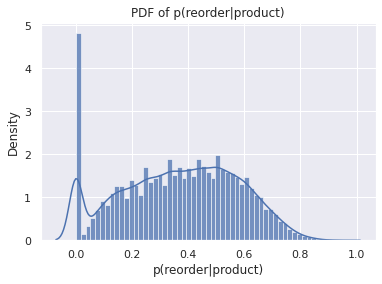

In [ ]:
sns.histplot(x=prod_info['p(reorder|product)'],stat='density')
sns.kdeplot(x=prod_info['p(reorder|product)'])
plt.title('PDF of p(reorder|product)');

**Analysis:**
- Many products are reordered 0 times. It means customers don't like these products.
- Otherwise, the PDF roughly looks like a bell-shaped curve with high std-dev.
- The PDF is little bit right skewed.

> **Conclusion:**
- There are only a few products with high reorder rate.
- Many product with reorder rate=0 are not liked by customers.

#### Q. Which products are best-sellers?
- BarPlot and Treemap of most reordered products.

In [ ]:
# products that are reordered most no. of times
top_reordered = prod_info.sort_values(['#times_reordered'],
                                      axis='index',
                                      ascending=False).iloc[:20,:]

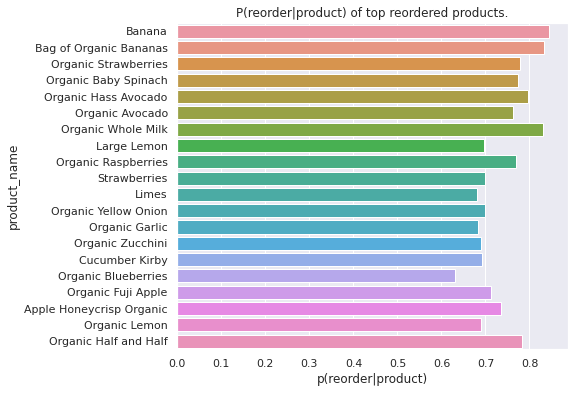

In [ ]:
fig,ax = plt.subplots(figsize=(7,6))
sns.barplot(y='product_name',x='p(reorder|product)',data=top_reordered,ax=ax)
plt.title('P(reorder|product) of top reordered products.')
plt.show()

# Treemap
fig = px.treemap(top_reordered, 
                 path=['department','aisle','product_name'],
                 values = 'p(reorder|product)',
                 title='P(reorder|product) of top reordered products with Department, Aisle')
fig.show()

**Analysis**
- Top 2 reordered products are Bananas with a very high order, reorder and probability value.
- People love to reorder organic products. 14 out of top 20 products are organic.
- Customers love to reorder fruits and vegetables. Except "Organic whole milk" & "Organic half and half" of "dairy eggs" department, all other products are either fruits or vegetables.
- Produce department has the largest number of top reordered products.
- P(reorder|products) of "Organic whole milk" & "Organic half and half" are comparable to that of "Bananas".

> **Conclusion:**
- Bananas, strawberries, raspberries, avocado, organic products, milk, Lemons are the most reordered and have a high p(reorder|product) value.

#### Q. Which products are the least reordered?
- Treemap of products reordered only 1-2 times.

In [ ]:
# products that are reordered least no. of times
least_reordered = prod_info.loc[prod_info['#times_reordered'].between(1,2),:]
print(f'{len(least_reordered)} products were reordered only 1-2 times.')

5173 products were reordered only 1-2 times.


In [ ]:
# Treemap
fig = px.treemap(least_reordered, 
                 path=['department','aisle','product_name'],
                 title='Treemap of least reordered products with Department, Aisle.')
# resizing figure
fig.update_layout(autosize=False,
                width=1050,
                height=1000,)
fig.show()

**Analysis:**
- Total more than 5K products which are reordered only 1-2 times.
- Personal care department alone has more than 1k products which are least reordered.
- Pantry and snacks department also has more than 500 products which are least reordered.
- Almost every department and aisle has some products which are least reordered.

> **Conclusion:**
- Around 10% percent of the total products are least reordered

#### Q. Which products are never reordered?
- Treemap of products which are never reordered.

In [ ]:
# products that are reordered least no. of times
never_reordered = prod_info.loc[prod_info['#times_reordered']==0,:]
print(f'{len(never_reordered)} products were never reordered.')
#never_reordered.head()

4085 products were never reordered.


In [ ]:
# Treemap
fig = px.treemap(never_reordered, 
                 path=['department','aisle','product_name'],
                 title='Treemap of never reordered products with Department, Aisle')
# resizing figure
fig.update_layout(autosize=False,
                width=1050,
                height=1000,)
fig.show()

In [ ]:
# products that are reordered least no. of times
never_ordered = prod_info.loc[prod_info['#times_ordered']==0,:]
print(f'{len(never_ordered)} products were never ordered.')
never_ordered.head()

3 products were never ordered.


,product_id,product_name,aisle_id,department_id,aisle,department,#times_ordered,#times_reordered,p(reorder|product)
8574,7045,Unpeeled Apricot Halves in Heavy Syrup,88,13,spreads,pantry,0,0,0.0
14299,46625,Single Barrel Kentucky Straight Bourbon Whiskey,31,7,refrigerated,beverages,0,0,0.0
38861,3630,Protein Granola Apple Crisp,57,14,granola,breakfast,0,0,0.0


**Analysis:**
- Almost 4K products were never reordered.
- Again, Personal care department has more than 1k products that were never reordrered.
- Except bulk department each department has some products which were never reordered.
- Three products "Unpeeled Apricot Halves in Heavy Syrup", "Single Barrel Kentucky Straight Bourbon Whiskey" and "Protein Granola Apple Crisp" were never ordered at all.

> **Conclusion:**
- Almost 8% of total products were never reordered.
- 3 products were never ordered.
- Customers don't like most products of Personal Care department.

#### Q. What are some hidden popular categories in Product names?
- BarPlot of mean no. of times reordered the products of popular category.

As we saw previously that most best-sellers are organic products. Similarly, there can be some other hidden categories in product names. I will find those and analyse.

- Criteria for Popular category:
    - Each non-stopword in a product name represents a category.
    - The category which is present in a product name with more #reorders is more popular.
    - The category which is present in more product names is more popular.


In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
# stopwords
stop = set(stopwords.words('english'))
stop = stop.union({'100','00', '001', '003', '004', '005', '007', '01', '013021', '02', '04', '09', '10', '1000', '10000', '10000mcg', '1000iu', '1000mcg', '1000mg', '100869', '100965', '100mg', '101', '101305', '101352', '101442', '101445', '101744', '103', '105', '105ct', '108', '10mg', '10n', '10oz', '11', '110', '1100', '112', '114', '115', '116', '118', '11oz', '11z', '12', '120', '1200', '1200mg', '1211062', '1211231', '123', '125', '1250', '125ct', '1280mg', '129', '12c', '12oz', '12z', '13', '1300', '132', '138', '14', '1400', '14000', '140ct', '144', '14oz', '15', '150', '1500', '150mg', '150w', '153', '156', '15oz', '16', '160ct', '166', '1664', '16oz', '17', '174', '1761', '18', '180', '1836', '1837', '185', '1879', '1893', '19', '192', '1942', '1f', '1n', '1pk', '1st', '1x', '20', '200', '2000', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '200ck', '200ct', '200mg', '201', '2010', '2011', '2012', '2013', '2014', '2015', '2025', '203', '2032bp', '205', '209', '20mg', '20oz', '21', '210', '2115', '216', '22', '220', '2200', '220mg', '23', '230', '24', '240', '240ct', '24_7', '24hr', '24oz', '25', '250', '2500', '250mg', '25mg', '25w', '26', '260', '27', '270ct', '275', '28', '28mg', '29', '2chic', '2ct', '2in1', '2lt', '2n', '2nd', '2oz', '2pk', '2t', '2x', '2z', '30', '300', '3000', '30000', '3000mcg', '300mg', '301', '305', '30c', '30oz', '30x', '31', '310', '311', '312', '32', '32000', '325', '32510', '325mg', '328', '32mg', '33', '335', '337', '34', '35', '357', '36', '360', '37', '375', '38', '38210', '39', '39or', '3d', '3dwhite', '3f', '3mg', '3n', '3oz', '3rd', '3s', '3t', '3x', '3x35ct', '40', '400', '4000', '400mg', '40w', '41', '42', '4200', '43', '44', '440', '45', '45000', '450mg', '454', '45ct', '46', '475', '48', '485', '48h', '49', '490', '4g', '4kids', '4n', '4oz', '4pk12oz', '4t', '4x', '50', '500', '5000', '500mcg', '500mg', '50mg', '51', '511', '5129732', '5160628', '5160666', '525', '53', '530', '54', '55', '550', '56', '57', '570', '580mg', '595', '5a', '5g', '5lb', '5m', '5mg', '5n', '5nb', '5oz', '5ph', '5t', '5x', '60', '600', '6000', '60000', '600mg', '60ct', '610', '62', '625', '62oz', '63', '635', '64', '65', '650', '65w', '66', '660', '667', '66oz', '67', '67oz', '68', '680', '6b', '6c', '6g', '6l', '6m', '6n', '6oz', '6pk', '70', '705', '71', '715', '72', '72ct', '73', '74', '75', '750', '7500', '75ea', '75oz', '76', '76oz', '78', '79', '7in', '7in1', '7n1', '7oz', '7up', '80', '800', '805', '81', '810', '81mg', '82', '825', '83', '84', '85', '850', '86', '87', '872', '875', '88', '89', '8ct', '8oz', '8pk12oz', '90', '9000', '902', '90708', '90mg', '91', '92', '93', '94', '946', '95', '951', '96', '97', '98', '99', '9ct', '9n', '9oz', '9v', 'a21', 'aa', 'aaa'})
# department names and aisle names need not be in the list of categories 
# as we already have information about these.
stop = stop.union(set(dep.department))
stop = stop.union(set(aisles.aisle))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
# list of product names is corpus and each product name is documnent.
# binary CountVectorizer will give an array showing if a product name belongs to a category or not.
vec = CountVectorizer(binary=True,stop_words=stop,)
vec.fit(prod_info.product_name)
X = vec.transform(prod_info.product_name)
print('Total number of hidden categories =',len(vec.get_feature_names()))
print('List of categories:',vec.get_feature_names())
# All the categories present in the product name is multiplied with the #times_reordered value
# to increase the weight of this category depicting how much this category is popular.
popularity_weight = prod_info['#times_reordered'].to_numpy().reshape(-1,1)
# multiplying each category with popularity weight and 
# summing the popularity of categories which are present in multiple product names.
popularity = (X.toarray()*popularity_weight).sum(axis=0)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['accessories', 'aid', 'air', 'allergy', 'alternatives', 'appetizers', 'applesauce', 'asian', 'baby', 'bacon', 'bags', 'bake', 'baking', 'bars', 'bath', 'beans', 'beers', 'body', 'bouillon', 'bowls', 'breads', 'broth', 'buns', 'cakes', 'candles', 'candy', 'canned', 'care', 'cat', 'champagnes', 'cheese', 'cheeses', 'chips', 'chocolate', 'cleaning', 'cocoa', 'cold', 'cookies', 'coolers', 'counter', 'creams', 'cups', 'dairy', 'decor', 'dessert', 'desserts', 'detergents', 'diapers', 'dips', 'dish', 'dog', 'dogs', 'doughs', 'dressing', 'dried', 'drink', 'drinks', 'dry', 'ear', 'energy', 'eye', 'facial', 'feminine', 'first', 'flat', 'flatware', 'flu', 'food', 'foods', 'formula', 'fresh', 'fresheners', 'fruit', 'fruits', 'gelatins', 'goods', 'grains', 'gum', 'hair', 'herbs', 'honeys', 'hot', 'hygiene

Total number of hidden categories = 10271
List of categories: ['abate', 'abbey', 'abc', 'abrasive', 'abruzzese', 'absolute', 'absolutely', 'absorb', 'absorbancy', 'absorbencies', 'absorbency', 'absorbenncy', 'absorbent', 'absorber', 'absorbing', 'abuelita', 'abundant', 'ac', 'acacia', 'acai', 'accelerator', 'accent', 'accents', 'access', 'accurate', 'aceita', 'acetaminophen', 'acetone', 'acetyl', 'ache', 'aches', 'achiote', 'acid', 'acidil', 'acidophilus', 'acini', 'acme', 'acne', 'acnedote', 'acnewash', 'aconitum', 'acorn', 'act', 'acti', 'actin', 'acting', 'action', 'actionpacs', 'activ', 'activated', 'activating', 'activator', 'active', 'activedry', 'activia', 'activity', 'actvated', 'adavanced', 'add', 'added', 'addictives', 'addictivly', 'additives', 'ade', 'adhering', 'adhesive', 'adige', 'adjustable', 'adobo', 'adore', 'adorn', 'adrenal', 'adrenaline', 'aduki', 'adul', 'adult', 'adults', 'advance', 'advancecare', 'advanced', 'advantage', 'advantedge', 'adventure', 'adventures', 

In [ ]:
category = pd.DataFrame({'category':vec.get_feature_names(),
                         'popularity':popularity})\
                         .sort_values('popularity',ascending=False)\
                         .reset_index(drop=True)

In [ ]:
# picking popular categories with popularity more than 200k
category = category.loc[category.popularity>=200000,'category']
print(f'Total {len(category)} top hidden categories in product names.')
np.array(category)

Total 62 top hidden categories in product names.


array(['organic', 'percent', 'cheese', 'banana', 'whole', 'free', 'water',
       'strawberry', 'baby', 'fat', 'original', 'apple', 'chocolate',
       'large', 'red', 'chicken', 'sparkling', 'greek', 'bag', 'vanilla',
       'avocado', 'almond', 'natural', 'white', 'spinach', 'cheddar',
       'lemon', 'juice', 'chips', 'green', 'sweet', 'brown', 'gluten',
       'coconut', 'orange', 'hass', 'wheat', 'reduced', 'unsweetened',
       'tomato', 'rice', 'salt', 'potato', 'total', 'blueberry', 'grain',
       'low', 'carrots', 'lowfat', 'plain', 'bar', 'fruit', 'extra',
       'roasted', 'yellow', 'beans', 'pepper', 'honey', 'turkey', 'grade',
       'fresh', 'onion'], dtype=object)

In [ ]:
# Adding these categories in prod_info dataframe
for cat in category:
    prod_info[cat] = prod_info.product_name.str.contains(cat,case=False).astype('Sparse[uint8]')
prod_info.head()

,product_id,product_name,aisle_id,department_id,aisle,department,eatable,#times_ordered,#times_reordered,p(reorder|product),organic,percent,cheese,banana,whole,free,water,strawberry,baby,fat,original,apple,chocolate,large,red,chicken,sparkling,greek,bag,vanilla,avocado,almond,natural,white,spinach,cheddar,lemon,juice,chips,green,sweet,brown,gluten,coconut,orange,hass,wheat,reduced,unsweetened,tomato,rice,salt,potato,total,blueberry,grain,low,carrots,lowfat,plain,bar,fruit,extra,roasted,yellow,beans,pepper,honey,turkey,grade,fresh,onion
0,1,Chocolate Sandwich Cookies,61,19,cookies cakes,snacks,1,1928,1185,0.614627,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,78,Nutter Butter Cookie Bites Go Pak,61,19,cookies cakes,snacks,1,12,4,0.333333,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,102,Danish Butter Cookies,61,19,cookies cakes,snacks,1,190,37,0.194737,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,172,Gluten Free All Natural Chocolate Chip Cookies,61,19,cookies cakes,snacks,1,99,72,0.727273,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,285,Mini Nilla Wafers Munch Pack,61,19,cookies cakes,snacks,1,168,62,0.369048,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


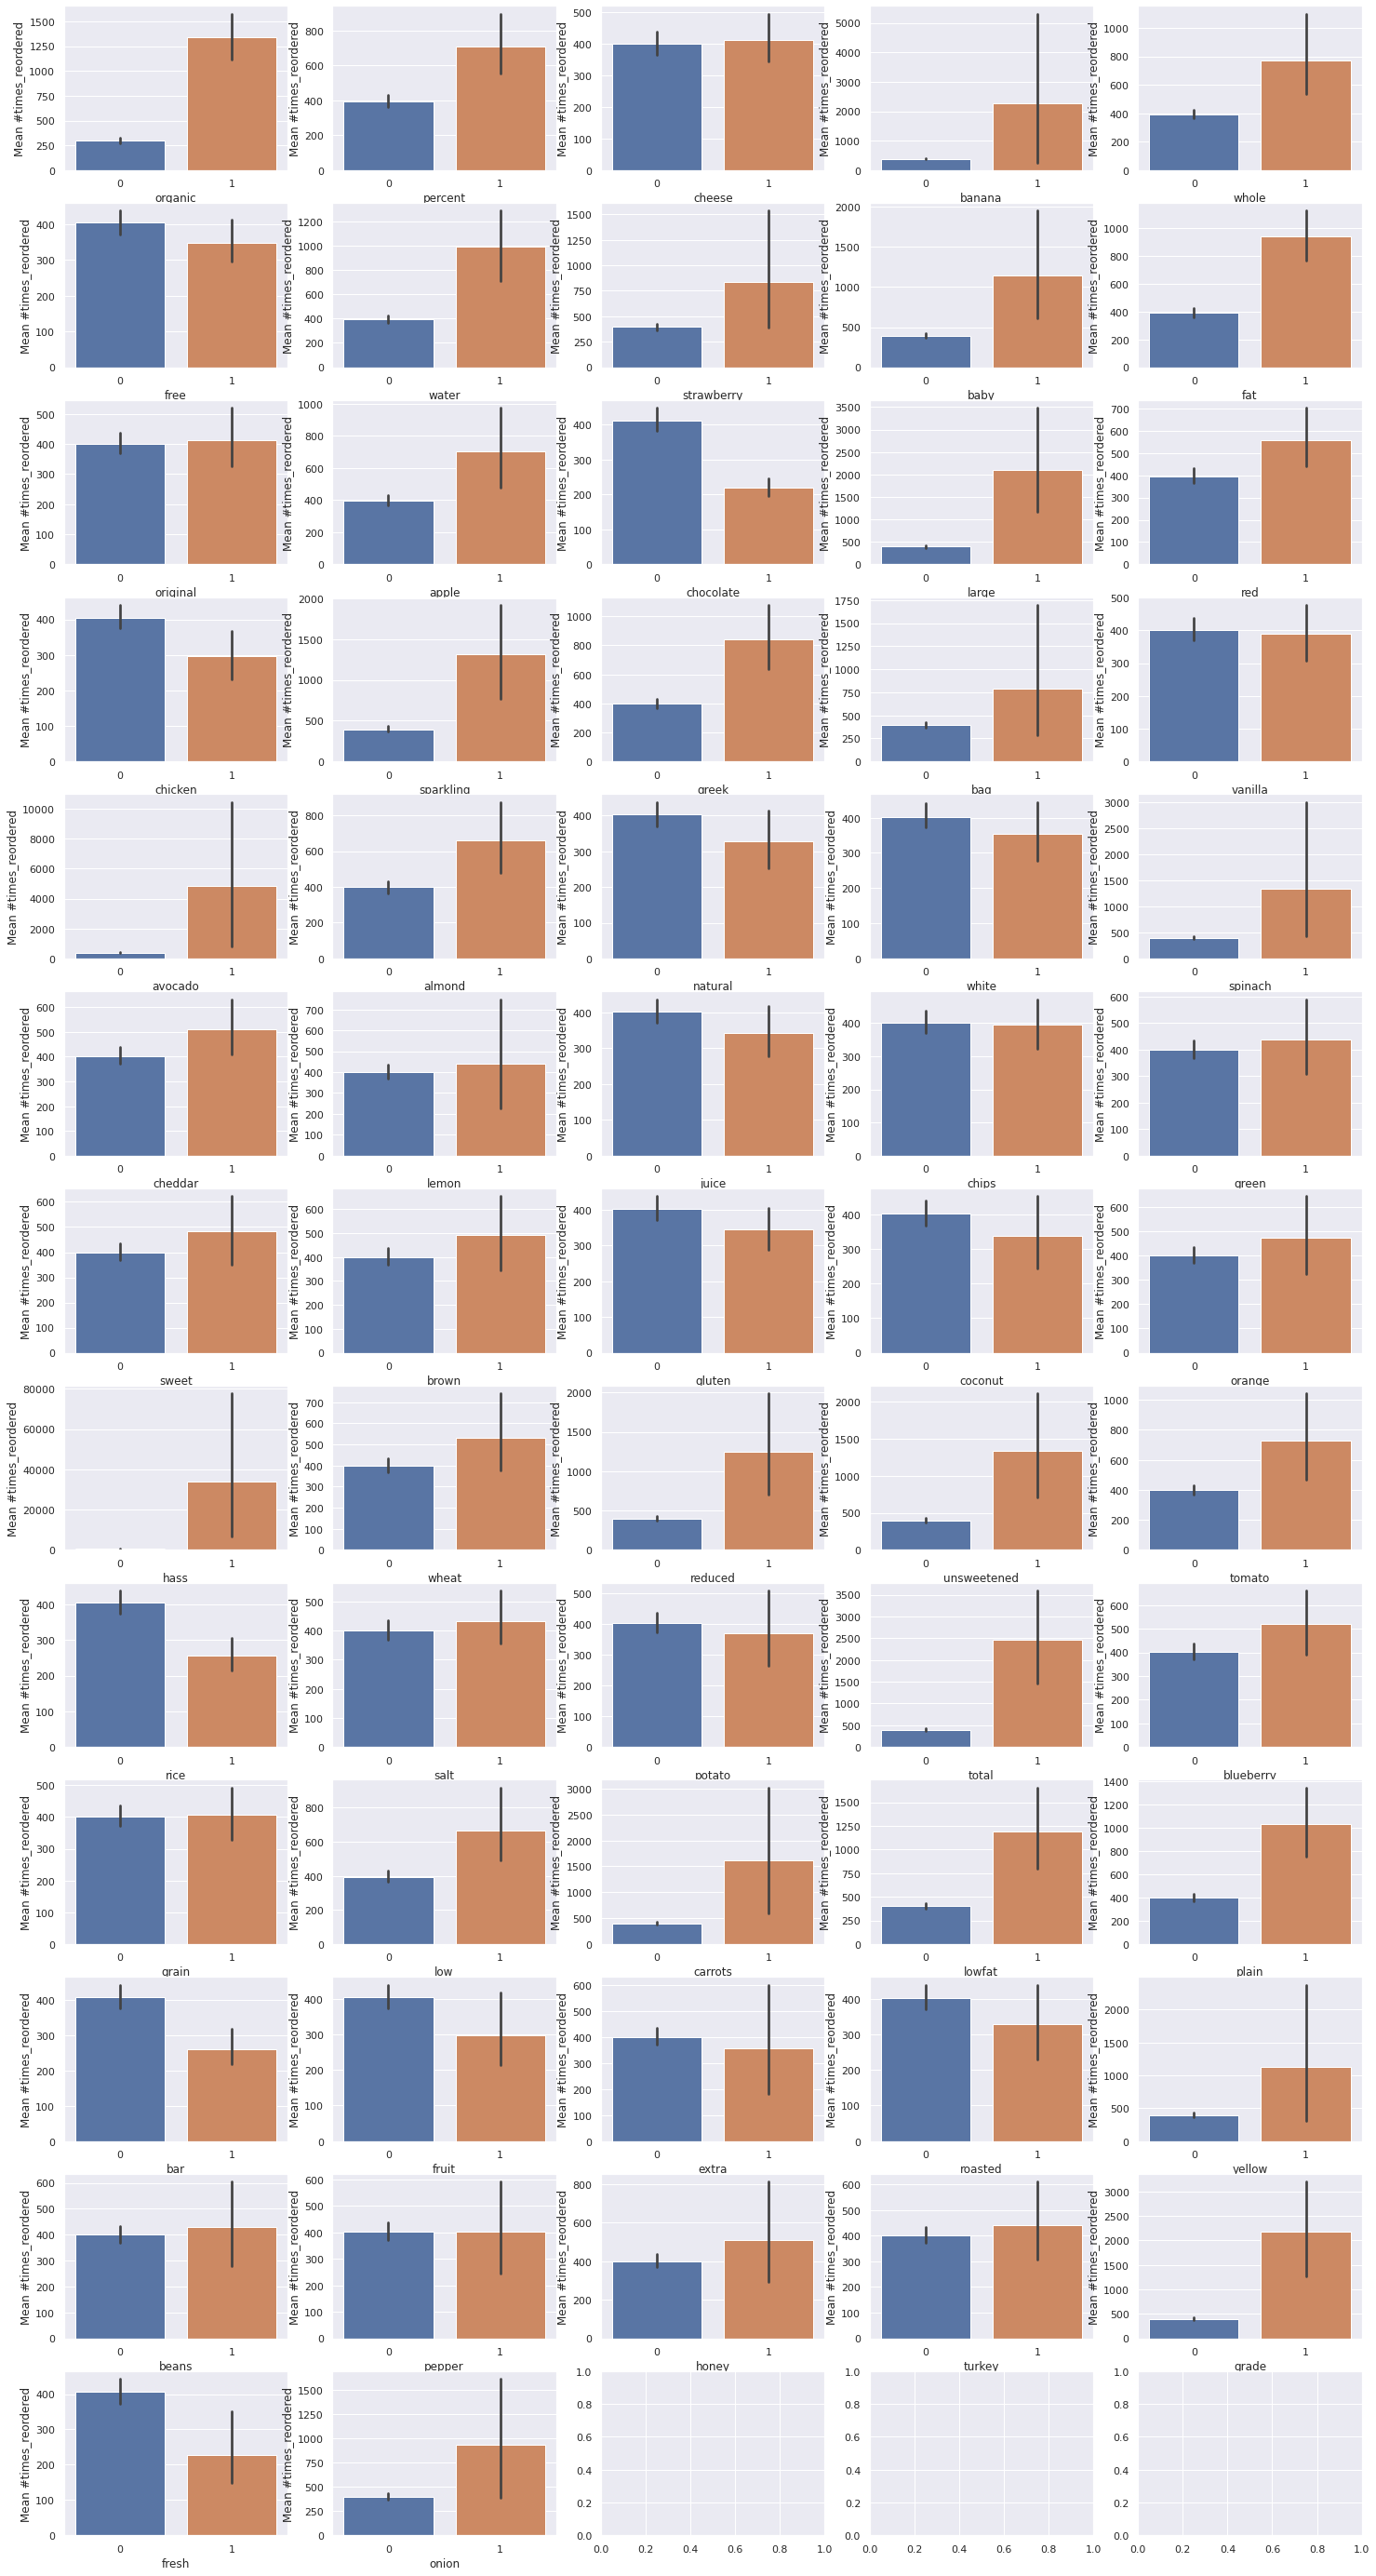

In [ ]:
fig, ax = plt.subplots(13,5,figsize=(25,50),)
i=0
for cat in category:
    plot = sns.barplot(data=prod_info,
                       x=cat,
                       y='#times_reordered',
                       estimator=np.mean,
                       ax=ax[i//5,i%5])
    plot.set_ylabel('Mean #times_reordered')
    i+=1
plt.show()

**Analysis:**
- Products of categories like organic, Banana, large, strawberry, hass, grade, carrots, total, plain, lowfat, unsweetened, reduced, sparkling, fat and baby categories are significantly ordered more.

> **Conclusion:**
- These 62 categories are important and tell a lot if a product belonging to these categories will be reordered or not.

#### Q. What is the probability of a customer reordering?
- PDF of p(reorder|user).

In [ ]:
user_info = data.groupby(['user_id'])['reordered'].agg(['sum','count','mean'])
user_info = user_info.reset_index().rename(columns={'sum':'#reordered_prod',
                                                    'count':'#ordered_prod',
                                                    'mean':'p(reorder|user)'})
# p(reorder|user) = #reordered products / #ordered products
user_info

,user_id,#reordered_prod,#ordered_prod,p(reorder|user)
0,1,51.0,70,0.728571
1,2,105.0,226,0.464602
2,3,55.0,88,0.625000
3,4,1.0,18,0.055556
4,5,18.0,46,0.391304
...,...,...,...,...
206204,206205,14.0,51,0.274510
206205,206206,135.0,285,0.473684
206206,206207,131.0,223,0.587444
206207,206208,479.0,677,0.707533


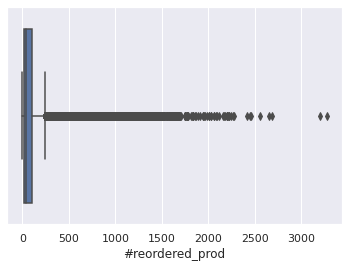

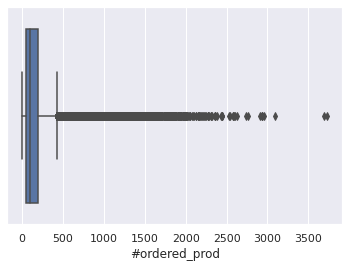

In [ ]:
sns.boxplot(data=user_info,x='#reordered_prod');
plt.title('BoxPlot of no. of reordered products by each user')
plt.show()
sns.boxplot(data=user_info,x='#ordered_prod');
plt.title('BoxPlot of no. of ordered products by each user')
plt.show()

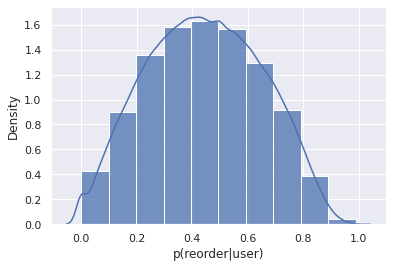

In [ ]:
sns.histplot(data=user_info,x='p(reorder|user)',bins=10,stat='density');
sns.kdeplot(data=user_info,x='p(reorder|user)')
plt.title('PDF of probability of reorder for each user.');

**Analysis:**
- Most users have ordered/reordered less than 250 products in total.
- There are some users who order/reorder very large no. of products.
- The pdf looks like a gaussian curve. Most of the customers have probability of 0.5 of reordering. And as we go away the probability decreases.

> **Conclusion:**
- Most of the customers try new products as well as they reorder the old products.

#### Q. What is the avg no. of products that a customer reorders?
- PDF of mean_#reordered_prod

In [ ]:
# number of reordered products in a user's order
num_prod = data.groupby(['user_id','order_id'])['reordered'].sum().reset_index()
# mean no. of products in user's all orders
mean_num_prod = num_prod.groupby('user_id')['reordered'].mean()\
                        .rename('mean_#reordered_prod')\
                        .reset_index()
# merge mean_num_prod and user_info
user_info = user_info.merge(mean_num_prod, on='user_id',)
user_info

,user_id,#reordered_prod,#ordered_prod,p(reorder|user),mean_#reordered_prod
0,1,51.0,70,0.728571,4.636364
1,2,105.0,226,0.464602,7.000000
2,3,55.0,88,0.625000,4.583333
3,4,1.0,18,0.055556,0.200000
4,5,18.0,46,0.391304,3.600000
...,...,...,...,...,...
206204,206205,14.0,51,0.274510,3.500000
206205,206206,135.0,285,0.473684,2.014925
206206,206207,131.0,223,0.587444,8.187500
206207,206208,479.0,677,0.707533,9.775510


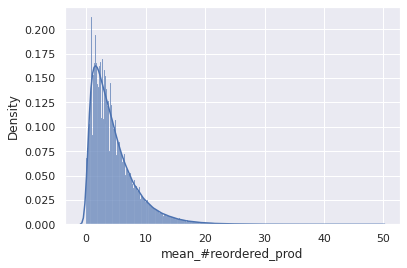

In [ ]:
sns.histplot(data=user_info,x='mean_#reordered_prod',stat='density');
sns.kdeplot(data=user_info,x='mean_#reordered_prod');

**Analysis:**
- Most customers reorder 5-10 products on avg in an order.
- As the pdf is right-skewed, there are some customers who reorder a lot on avg in an order.

> **Conclusion:**
- The average no. of reorders of customer is between 5-10.
- There are some customers who reorder a lot.

---

